# Introduction
In this notebook, I will conduct some statistical tests to valididate HN DLC for without contrast CTs.

The dataset for testing the baseline contains 141 patients that have with- anfd without- contrast CTs, and also manual, with and without contrast DLC masks. Moreover, for week3 I have a dataset contains 68 patients that have manual and DLC masks.

I will coonduct FOUR different statistical comparison here.

In [1]:
# Import packages

# General packages
import os
import re
import math
import seaborn as sns
import shutil
import scipy.ndimage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D 

# Image analysis packages
import cv2
import pydicom
from pydicom.tag import Tag
import nibabel as nib
import SimpleITK as sitk
import seg_metrics.seg_metrics as sg
from radiomics import featureextractor
from surface_distance import metrics
from surface_distance.metrics import *
from skimage.draw import polygon
from PIL import Image, ImageDraw

First I need to complete the dataset. One of the patients' RF should be extracted. 

In [2]:
bsl_without_contrast_nifti_path = '//zkh/appdata/RTDicom/Projectline_HNC_modelling/OPC_data/ART Hooman/Hooman_project_data/DLC_baseline_without_contrast_NIFTI'
bsl_without_contrast_dicom_path = '//zkh/appdata/RTDicom/Projectline_HNC_modelling/OPC_data/ART Hooman/Hooman_project_data/DLC_baseline_without_contrast'
bsl_without_contrast_rf = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/DLC_baseline_without_contrast_radiomics_features1.xlsx'
mc_without_contrast_rf = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_mc_checker_total.xlsx'

In [3]:
dlc_available_rf_df = pd.read_excel(bsl_without_contrast_rf).drop(columns=['Unnamed: 0'])
dlc_available_rf_df.ID.nunique()

138

In [ ]:
mc_available_rf_df = pd.read_excel(mc_without_contrast_rf)
mc_available_rf_df['Unnamed: 0'] = mc_available_rf_df['Unnamed: 0'].fillna(method='ffill')
mc_available_rf_df.rename(columns= {'Unnamed: 0':'ID', 'Unnamed: 1': 'OAR'}, inplace=True)
mc_available_rf_df.ID = mc_available_rf_df.ID.astype(int)
mc_available_rf_df.head()

In [5]:
dlc_available_rf_df.ID.nunique()

138

In [6]:
total_id_set = set()

In [7]:
for r, d, f in os.walk(bsl_without_contrast_dicom_path):
    subfolders = [os.path.join(r, folder) for folder in d]
    
    for subf in subfolders:
        if subf.split('\\')[1] not in total_id_set:
            total_id_set.add(int(subf.split('\\')[1]))

Now, I have all the datasets. I first make them here and then I will start to evaluate them.

In [11]:
mc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_mc_checker_total.xlsx'
dlc_bsl_with_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_dlc_total.xlsx'
dlc_bsl_without_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_dlc_withoutC_total.xlsx'

In [12]:
# Make dataset with manual contouring and deep learning and without contrast.
mc_bsl_df = pd.read_excel(mc_bsl_path).drop(columns=['Unnamed: 0'])
dlc_bsl_without_df = pd.read_excel(dlc_bsl_without_path).drop(columns=['Unnamed: 0'])

In [13]:
# Make dataset with contrast and deep learning contouring
dlc_bsl_with_df = pd.read_excel(dlc_bsl_with_path)
dlc_bsl_with_df['Unnamed: 0'] = dlc_bsl_with_df['Unnamed: 0'].fillna(method='ffill')
dlc_bsl_with_df.rename(columns= {'Unnamed: 0':'ID', 'Unnamed: 1': 'OAR'}, inplace=True)
dlc_bsl_with_df.ID = dlc_bsl_with_df.ID.astype(int)
dlc_bsl_with_df = dlc_bsl_with_df[dlc_bsl_with_df.ID.isin(list(mc_bsl_df.ID.unique()))]
dlc_bsl_with_df.ID.nunique()

140

So, I will erase this one from the datasets.

In [15]:
mc_bsl_df = mc_bsl_df[~(mc_bsl_df.ID.astype(str).str.contains('1737477'))].reset_index().drop(columns=['index'])
dlc_bsl_without_df = dlc_bsl_without_df[~(dlc_bsl_without_df.ID.astype(str).str.contains('1737477'))].reset_index().drop(columns=['index'])

In [16]:
mc_total_df = mc_bsl_df[mc_bsl_df.OAR == 'total']
dlc_with_total_df = dlc_bsl_with_df[dlc_bsl_with_df.OAR == 'total']
dlc_without_total_df = dlc_bsl_without_df[dlc_bsl_without_df.OAR == 'total']

# Functions
I put all the statistical functions here.

In [33]:
def making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, line=False, line_inf = []):
    plt.figure(figsize=(10,10))

    for counter, x_element in enumerate(x_element_list): 
        plt.scatter(x=x_element, y=y_element_list[counter], color=color_list[counter], alpha=alpha_list[counter], marker='o', label=label_list[counter])
    
    if line:
        plt.plot(line_inf[0], line_inf[1], label=line_inf[2])
        
    # Add labels to the plot
    plt.xlabel(figure_dict['x'])
    plt.ylabel(figure_dict['y'])

    # Add a title to the plot
    plt.title(figure_dict['title'])

    # Add a legend to the plot
    plt.legend()

    # Save this plot
    plt.savefig('surface_vol.png')
    # Display the plot
    plt.show()

def making_histogram(element_list, color_list, label_list, alpha_list, figure_dict):
    # Create a histogram
    plt.figure(figsize=(10, 5))
    plt.hist(element_list[0], bins=30, color=color_list[0], density=True, edgecolor='black', alpha=0.7, label=label_list[0])
    plt.hist(element_list[1], bins=30, color=color_list[1], density=True, edgecolor='black', alpha=0.5, label=label_list[1])


    # Add a line plot (probability density function)
    sns.kdeplot(element_list[0], color='red', linestyle='dashed')
    sns.kdeplot(element_list[1], color='darkgreen', linestyle='dashed')


    plt.axvline(x = np.mean(element_list[0]), color = "red", linestyle='--', label=f'Mean {label_list[0]}')
    plt.axvline(x = np.mean(element_list[1]), color = "darkgreen", linestyle='--', label=f'Mean {label_list[1]}')


    # Add labels to the plot
    plt.xlabel(figure_dict['x'])
    plt.ylabel(figure_dict['y'])

    # Add a title to the plot
    plt.title(figure_dict['title'])

    # Add a legend to the plot
    plt.legend()

    # Save this plot
    plt.savefig('distribution.png')

    # Display the plot
    plt.show()

def DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.2):
    """
    *
    Function DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)
     
       This function performs a paired t-test (Null Hypothesis Significance Test) 
       in the spirit of R, testing 2 averages of paired data with *unknown* standard deviation.
       The function also evaluates the effect size (Cohen's d).
       
    Requires:          -
       
    Usage:             DS_paired_ttest_means(y1, y2, 
                            alternative=['two-sided']/'less'/'greater', 
                            alpha = 0.05)
     
                         alternative = 'two-sided' [default]  H1: mu_1 != mu_2
                                       'less'                 H1: mu_1 < mu_2
                                       'greater'              H1: mu_1 > mu_2
                         alpha:   significance level of test [default: 0.05]
     
    Return:            t, p-value, t.crit.L, t.crit.R  [ + print interpretable output to stdout ]
                       where t.crit.L and t.crit.R are the lower and upper critical values, 
                       t is the test statistic and p-value is the p-value of the test.     
    
    Author:            M.E.F. Apol
    Date:              2020-11-11, rev. 2022_08_26
    Validation:
    """
    
    from scipy.stats import ttest_rel
    from scipy.stats import t as t_distr
    import numpy as np
    
    # Error checking:
    if len(y1) != len(y2):
        print('Error: Datasets of unequal length...')
        return
    
    t, p_samp = ttest_rel(y1, y2)
    y_av_1 = np.mean(y1)
    y_av_2 = np.mean(y2)
    d_av = y_av_1 - y_av_2
    n_d = len(y1)
    df = n_d - 1
    s2_1 = np.var(y1, ddof=1)
    s2_2 = np.var(y2, ddof=1)
    print(80*'-')
    print('Paired t-test for 2 means:')
    print('     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2')
    print('y.av.1 = {:.3g}, y.av.2 = {:.3g}, s2.1 = {:.3g}, s2.2 = {:.3g}, n.1 = {:d}, n.2 = {:d}, alpha = {:.3g}'.format(y_av_1, y_av_2, s2_1, s2_2, n_d, n_d, alpha))
    print('H0: mu.1  = mu.2')
    if alternative == 'two-sided':
        print('H1: mu.1 != mu.2')
        p_value = p_samp
        t_crit_L = t_distr.ppf(alpha/2, df)
        t_crit_R = t_distr.ppf(1-alpha/2, df)
    elif alternative == 'less':
        print('H1: mu.1  < mu.2')
        if t <= 0:
            p_value = p_samp/2
        else:
            p_value = 1 - p_samp/2
        t_crit_L = t_distr.ppf(alpha, df)
        t_crit_R = float('inf')
    elif alternative == 'greater':
        print('H1: mu.1  > mu.2')
        if t >= 0:
            p_value = p_samp/2
        else:
            p_value = 1 - p_samp/2
        t_crit_L = float('-inf')
        t_crit_R = t_distr.ppf(1-alpha, df)
    else:
        print('Wrong alternative hypothesis chosen!')
        print(80*'-' + '\n')
        t, p_value, t_crit_L, t_crit_R = np.nan, np.nan, np.nan, np.nan
        return(t, p_value, t_crit_L, t_crit_R)
    # Effect size:
    d_av = (y_av_1 - y_av_2) / np.sqrt((s2_1 + s2_2)/2)
    print('t = {:.4g}, p-value = {:.4g}, t.crit.L = {:.4g}, t.crit.R = {:.4g}, df = {:.4g}'.format(t, p_value, t_crit_L, t_crit_R, df))
    print('Effect size: d.av = {:.3g}; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large'.format(d_av))
    print(80*'-' + '\n')
    return(t, p_value, t_crit_L, t_crit_R)

def DS_Q_Q_Plot(y, est = 'robust', **kwargs):
    """
    *
    Function DS_Q_Q_Plot(y, est = 'robust', **kwargs)
    
       This function makes a normal quantile-quantile plot (Q-Q-plot), also known
       as a probability plot, to visually check whether data follow a normal distribution.
    
    Requires:            - 
    
    Arguments:
      y                  data array
      est                Estimation method for normal parameters mu and sigma:
                         either 'robust' (default), or 'ML' (Maximum Likelihood),
                         or 'preset' (given values)
      N.B. If est='preset' than the *optional* parameters mu, sigma must be provided:
      mu                 preset value of mu
      sigma              preset value of sigma
      
    Returns:
      Estimated mu, sigma, n, and expected number of datapoints outside CI in Q-Q-plot.
      Q-Q-plot
      
    Author:            M.E.F. Apol
    Date:              2020-01-06, revision 2022-08-30
    """
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Calculate order statistic:
    y_os = np.sort(y)
  
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.var(y)
    sigma_ML = np.std(y) # biased estimate
    s2 = np.var(y, ddof=1)
    s = np.std(y, ddof=1) # unbiased estimate
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        return()
        
    print('Estimation method: ' + est)
    print('n = {:d}, mu = {:.4g}, sigma = {:.4g}'.format(n, mu,sigma))
    
    # Expected number of deviations (95% confidence level):
    n_dev = np.round(0.05*n)
    
    print('Expected number of data outside CI: {:.0f}'.format(n_dev))
         
    # Perform z-transform: sample quantiles z.i
    z_i = (y_os - mu)/sigma

    # Calculate cumulative probabilities p.i:
    i = np.array(range(n)) + 1
    p_i = (i - 0.5)/n

    # Calculate theoretical quantiles z.(i):
    from scipy.stats import norm
    z_th = norm.ppf(p_i, 0, 1)

    # Calculate SE or theoretical quantiles:
    SE_z_th = (1/norm.pdf(z_th, 0, 1)) * np.sqrt((p_i * (1 - p_i)) / n)

    # Calculate 95% CI of diagonal line:
    CI_upper = z_th + 1.96 * SE_z_th
    CI_lower = z_th - 1.96 * SE_z_th

    # Make Q-Q plot:
    plt.plot(z_th, z_i, 'o', color='k', label='experimental data')
    plt.plot(z_th, z_th, '--', color='r', label='normal line')
    plt.plot(z_th, CI_upper, '--', color='b', label='95% CI')
    plt.plot(z_th, CI_lower, '--', color='b')
    plt.xlabel('Theoretical quantiles, $z_{(i)}$')
    plt.ylabel('Sample quantiles, $z_i$')
    plt.title('Q-Q plot (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    pass;


def normalizing_feature(x):
    normalized_x = (x - np.mean(x)) / np.std(x)
    return normalized_x


# First Baseline comparison (Manual Vs With-Contrast  masks)


I will compare three different parameters here (volume, surface area, and normal dice). Also, I will make scatter plots, histogram, and t-test.

In [ ]:
dlc_with_total_df = dlc_with_total_df.set_index('ID').sort_index()
mc_total_df = mc_total_df.set_index('ID').sort_index()

mc = mc_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]
dlc_with = dlc_with_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]

### Scatter Plots
First of all I want to make some scatter plots rekated to surface area and volume.

I will make three different scatter plots. First, volume as the x-axis and surface-area as the y-axis. next, I will make two scatter plots based on the index of the patients and the feature.

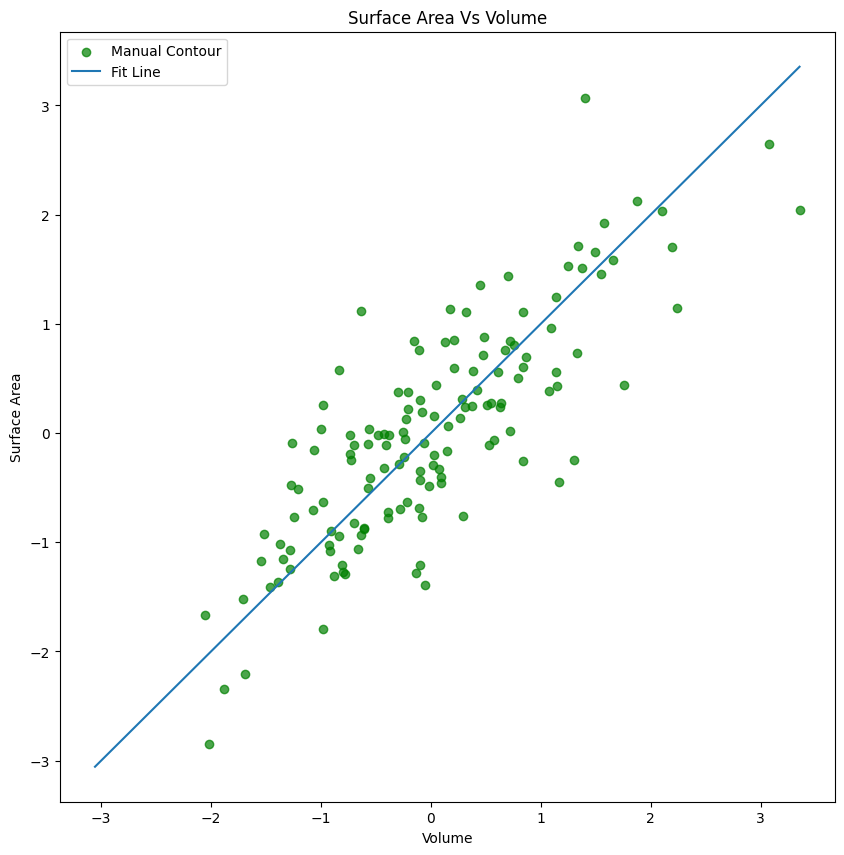

In [38]:
x_element_list = [normalizing_feature(mc.original_shape_SurfaceArea)]
y_element_list = [normalizing_feature(dlc_with.original_shape_SurfaceArea)]

line_info= [[np.min(normalizing_feature(mc.original_shape_SurfaceArea)) - 1, np.max(normalizing_feature(mc.original_shape_SurfaceArea))], 
            [np.min(normalizing_feature(mc.original_shape_SurfaceArea))- 1, np.max(normalizing_feature(mc.original_shape_SurfaceArea))], 'Fit Line']
color_list = ['green']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict, True, line_info)

#### 1- surface area vs volume

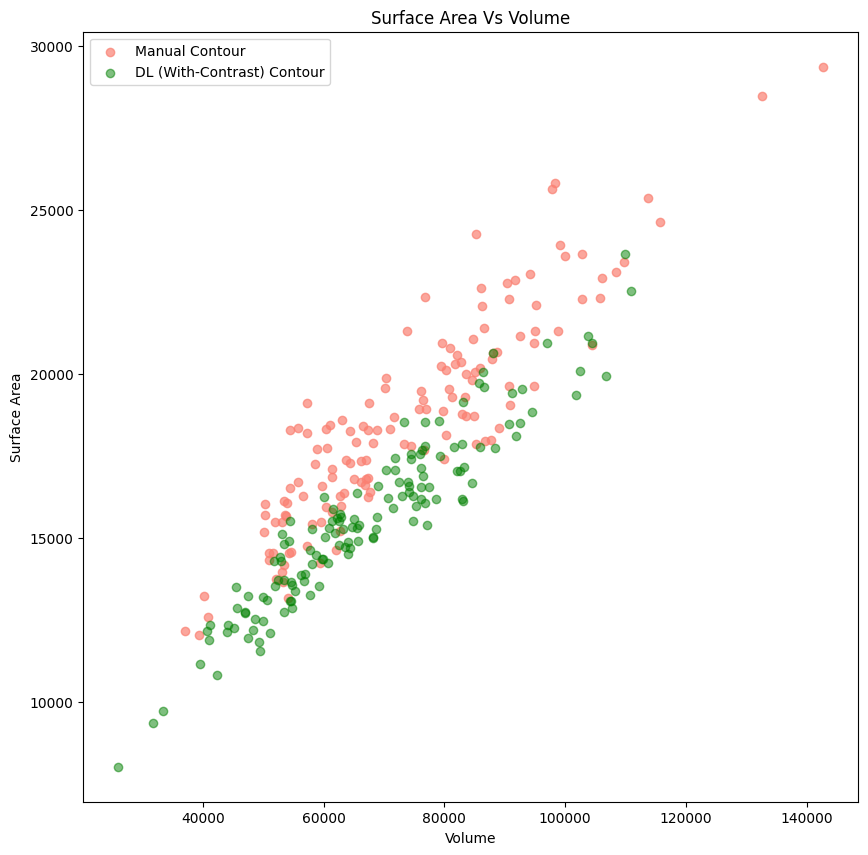

In [332]:
x_element_list = [mc.original_shape_VoxelVolume, dlc_with.original_shape_VoxelVolume]
y_element_list = [mc.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

#### 2- Surface Area Vs Index

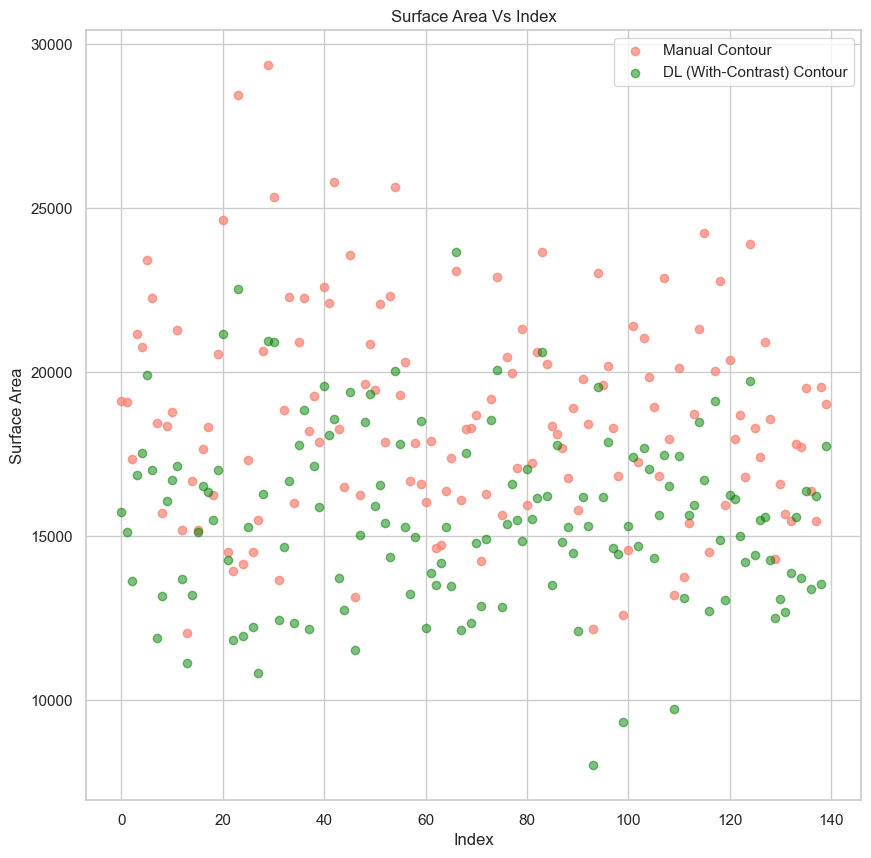

In [20]:
x_element_list = [mc.reset_index().index, mc.reset_index().index]
y_element_list = [mc.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Surface Area', 'title':'Surface Area Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

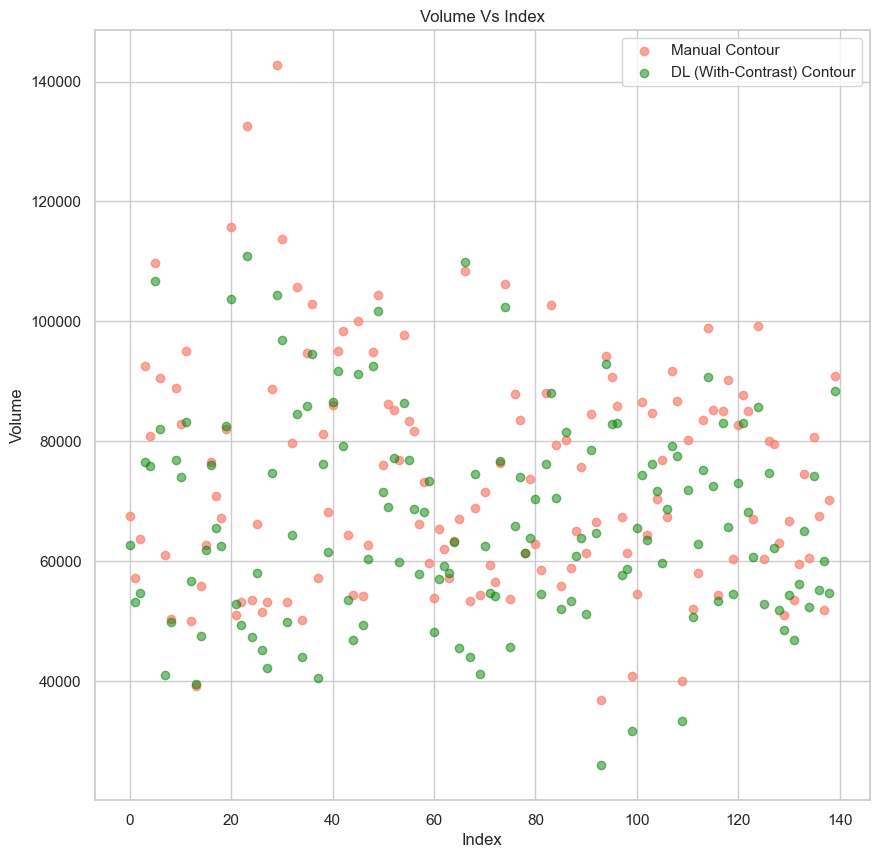

In [21]:
x_element_list = [mc.reset_index().index, mc.reset_index().index]
y_element_list = [mc.original_shape_VoxelVolume, dlc_with.original_shape_VoxelVolume]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Volume', 'title':'Volume Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram
I will make two different histograms. One for volume and another one for surface area.

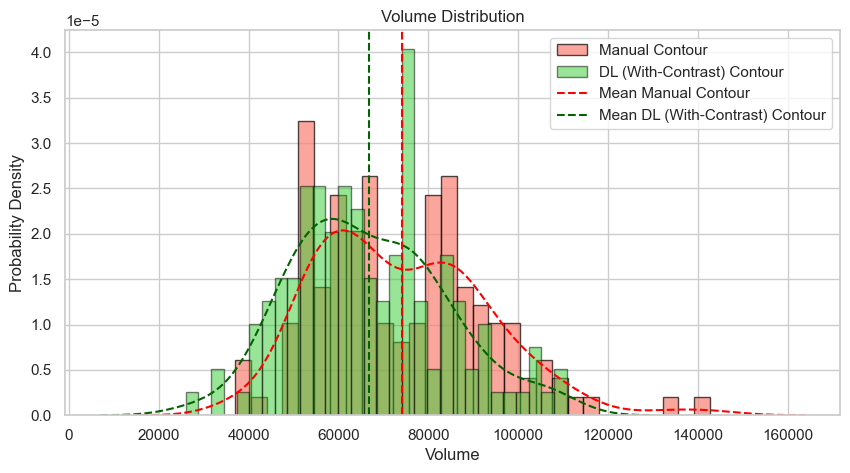

In [22]:
element_list = [mc.original_shape_VoxelVolume, dlc_with.original_shape_VoxelVolume]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

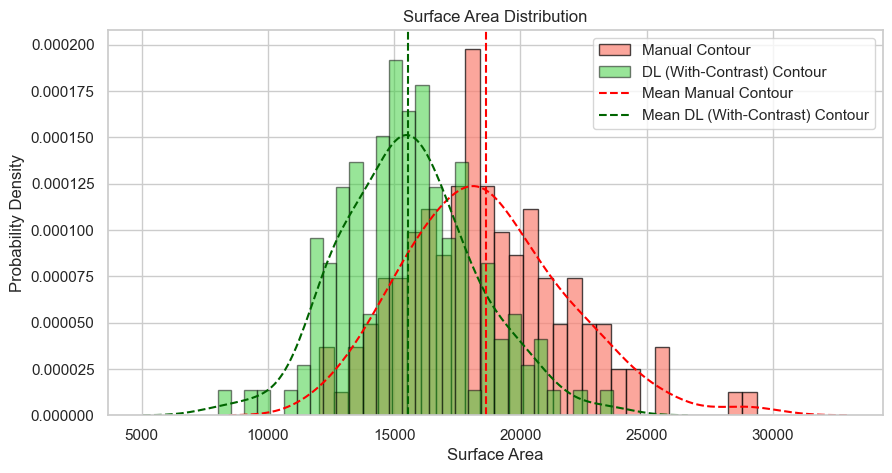

In [23]:
element_list = [mc.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area', 'y': 'Probability Density', 'title':'Surface Area Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Q-Q Plot

#### Surface:

Estimation method: robust
n = 140, mu = 1.831e+04, sigma = 3134
Expected number of data outside CI: 7


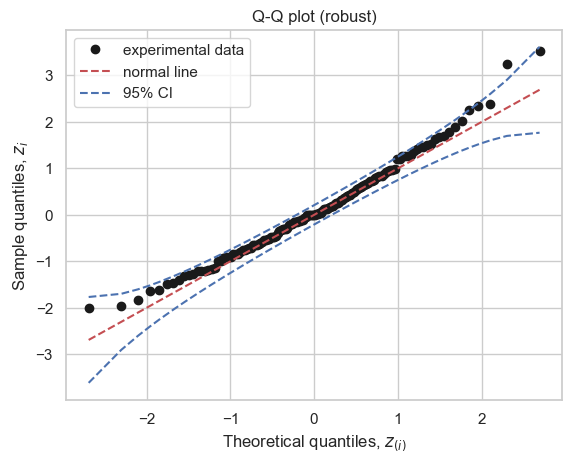

Estimation method: robust
n = 140, mu = 1.545e+04, sigma = 2526
Expected number of data outside CI: 7


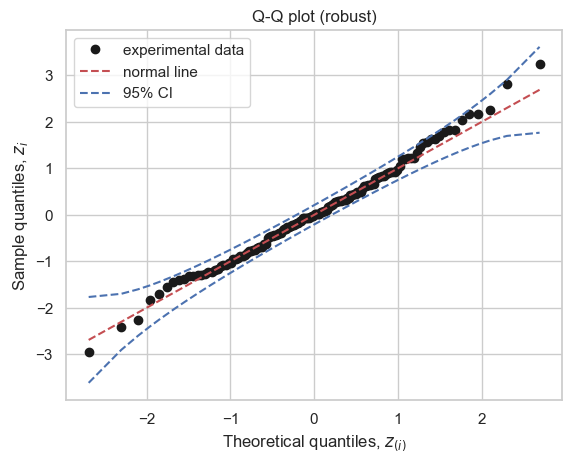

In [24]:
DS_Q_Q_Plot(mc.original_shape_SurfaceArea, est = 'robust')
DS_Q_Q_Plot(dlc_with.original_shape_SurfaceArea, est = 'robust')

#### Volume:

Estimation method: robust
n = 140, mu = 7.067e+04, sigma = 1.97e+04
Expected number of data outside CI: 7


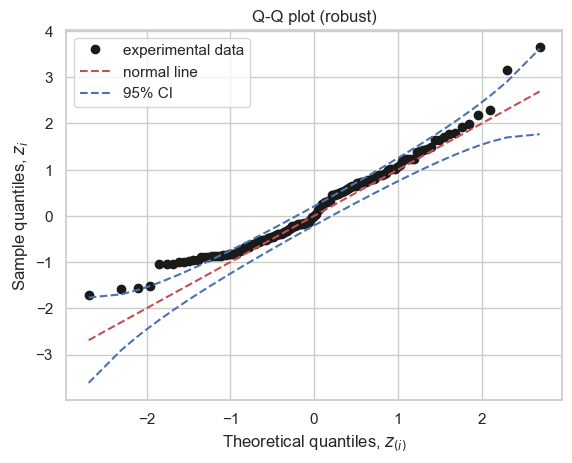

Estimation method: robust
n = 140, mu = 6.455e+04, sigma = 1.665e+04
Expected number of data outside CI: 7


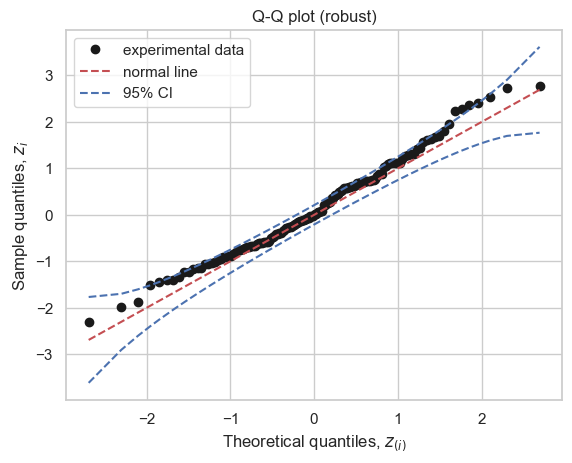

In [25]:
DS_Q_Q_Plot(mc.original_shape_VoxelVolume, est = 'robust')
DS_Q_Q_Plot(dlc_with.original_shape_VoxelVolume, est = 'robust')

### Paired T-test

Here I will impelemnt TWO t-test. One for surface and the other for volume

Surface:

In [26]:
y1 = mc.original_shape_SurfaceArea
y2 = dlc_with.original_shape_SurfaceArea
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 1.86e+04, y.av.2 = 1.55e+04, s2.1 = 1.03e+07, s2.2 = 7.04e+06, n.1 = 140, n.2 = 140, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = 19.44, p-value = 1.76e-41, t.crit.L = -1.977, t.crit.R = 1.977, df = 139
Effect size: d.av = 1.04; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(19.4435497546873,
 1.7597038754260975e-41,
 -1.9771777244761224,
 1.977177724476122)

Volume:

In [27]:
y1 = mc.original_shape_VoxelVolume
y2 = dlc_with.original_shape_VoxelVolume
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 7.41e+04, y.av.2 = 6.69e+04, s2.1 = 3.57e+08, s2.2 = 2.9e+08, n.1 = 140, n.2 = 140, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = 11.87, p-value = 7.235e-23, t.crit.L = -1.977, t.crit.R = 1.977, df = 139
Effect size: d.av = 0.4; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(11.865903566903834,
 7.234906193622695e-23,
 -1.9771777244761224,
 1.977177724476122)

### Normalized dataset
I thought alot about my problem, and I thought that it should be a way with which I can prove that these two contouring methods can work barely the same for me. So, I found that first we will normalize the dataset, then use the normalized data as the input of our model. Consequently, I'll  redo all the statistics again for normalized dataset. 

In [28]:
norm_mc_vol = normalizing_feature(mc.original_shape_VoxelVolume)
norm_with_vol = normalizing_feature(dlc_with.original_shape_VoxelVolume)
norm_mc_surf = normalizing_feature(mc.original_shape_SurfaceArea)
norm_with_surf = normalizing_feature(dlc_with.original_shape_SurfaceArea)

### Scatter 

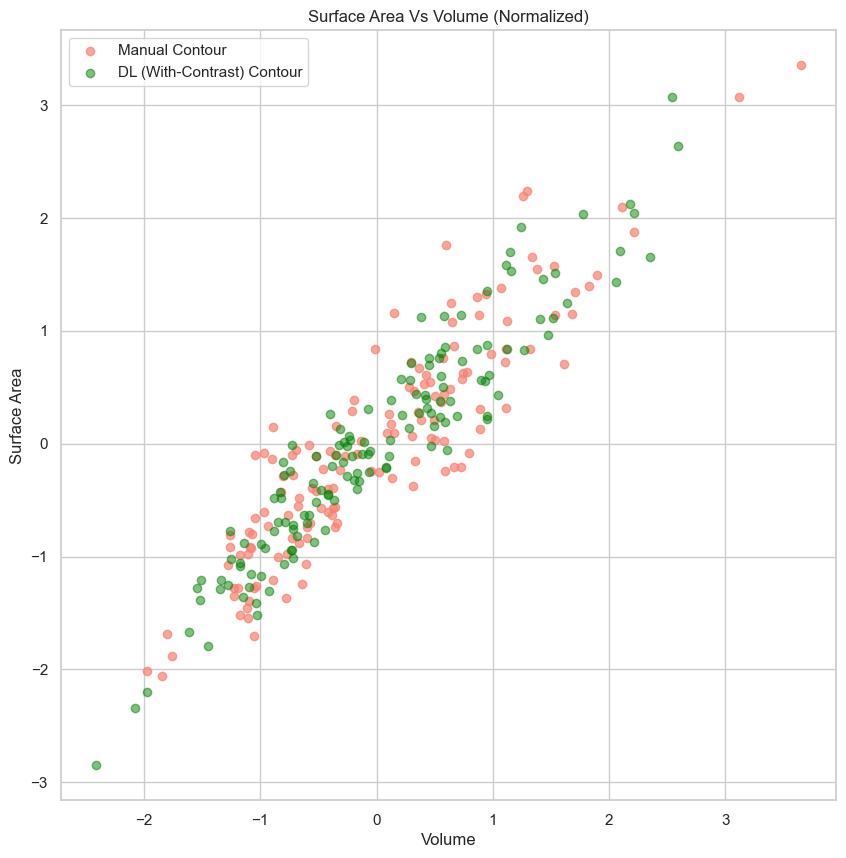

In [29]:
x_element_list = [norm_mc_vol, norm_with_vol]
y_element_list = [norm_mc_surf, norm_with_surf]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume (Normalized)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram

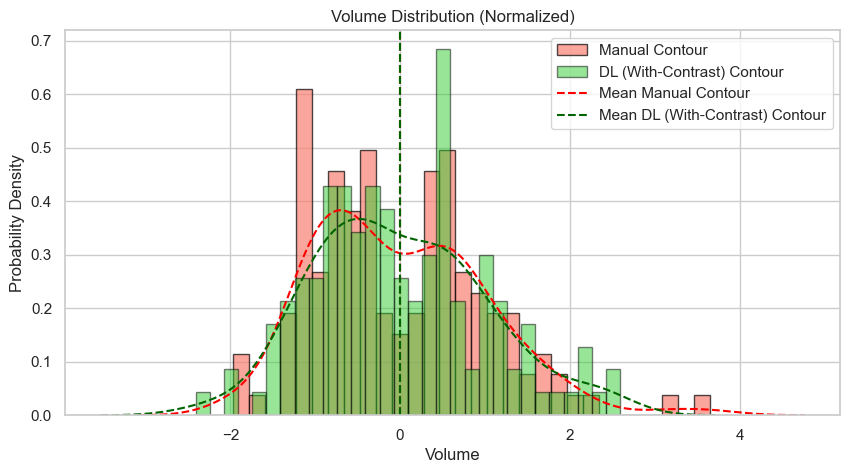

In [30]:
element_list = [norm_mc_vol, norm_with_vol]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

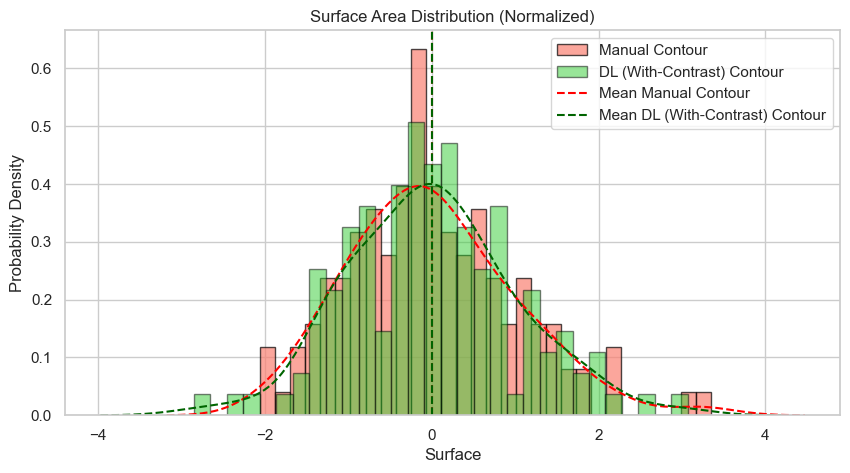

In [31]:
element_list = [norm_mc_surf, norm_with_surf]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface', 'y': 'Probability Density', 'title':'Surface Area Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Substraction

#### Surface

In [32]:
substratction = normalizing_feature(mc.original_shape_SurfaceArea - dlc_with.original_shape_SurfaceArea)
subtraction_norm = norm_mc_surf - norm_with_surf

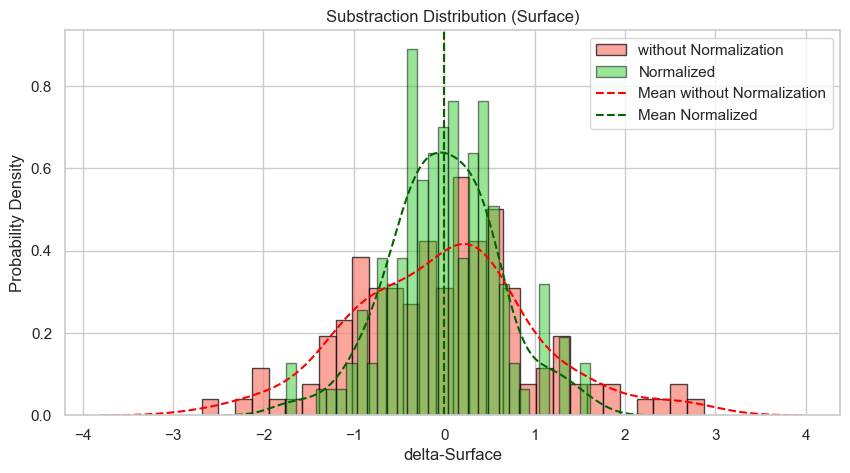

In [33]:
element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'delta-Surface', 'y': 'Probability Density', 'title':'Substraction Distribution (Surface)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

#### Volume

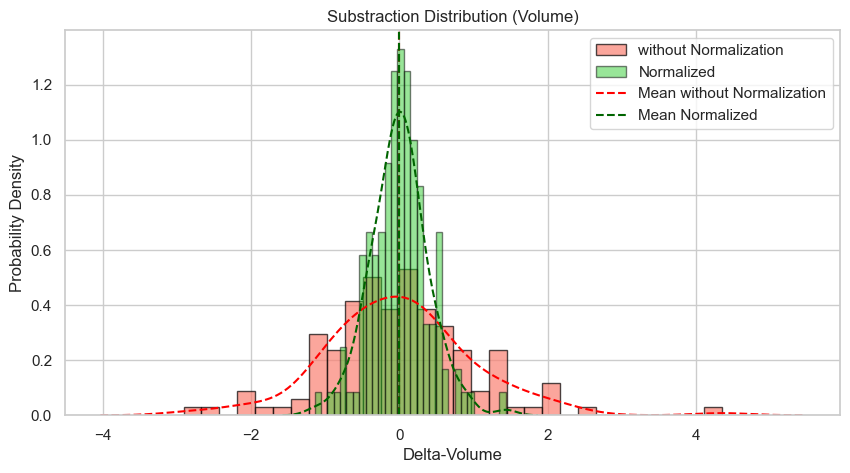

In [34]:
substratction = normalizing_feature(mc.original_shape_VoxelVolume - dlc_with.original_shape_VoxelVolume)
subtraction_norm = norm_mc_vol - norm_with_vol

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Volume', 'y': 'Probability Density', 'title':'Substraction Distribution (Volume)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

# Manual Vs Without Contrast


In [35]:
dlc_without_total_df = dlc_without_total_df.set_index('ID').sort_index()

dlc_without = dlc_without_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]


### Scatter

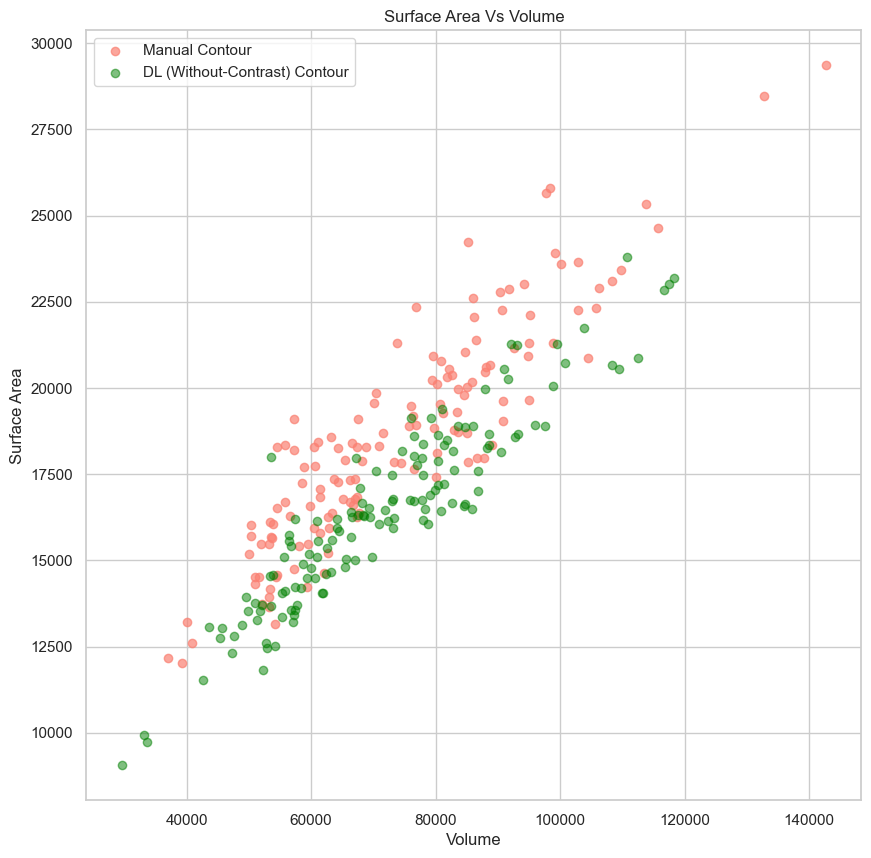

In [36]:
x_element_list = [mc.original_shape_VoxelVolume, dlc_without.original_shape_VoxelVolume]
y_element_list = [mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

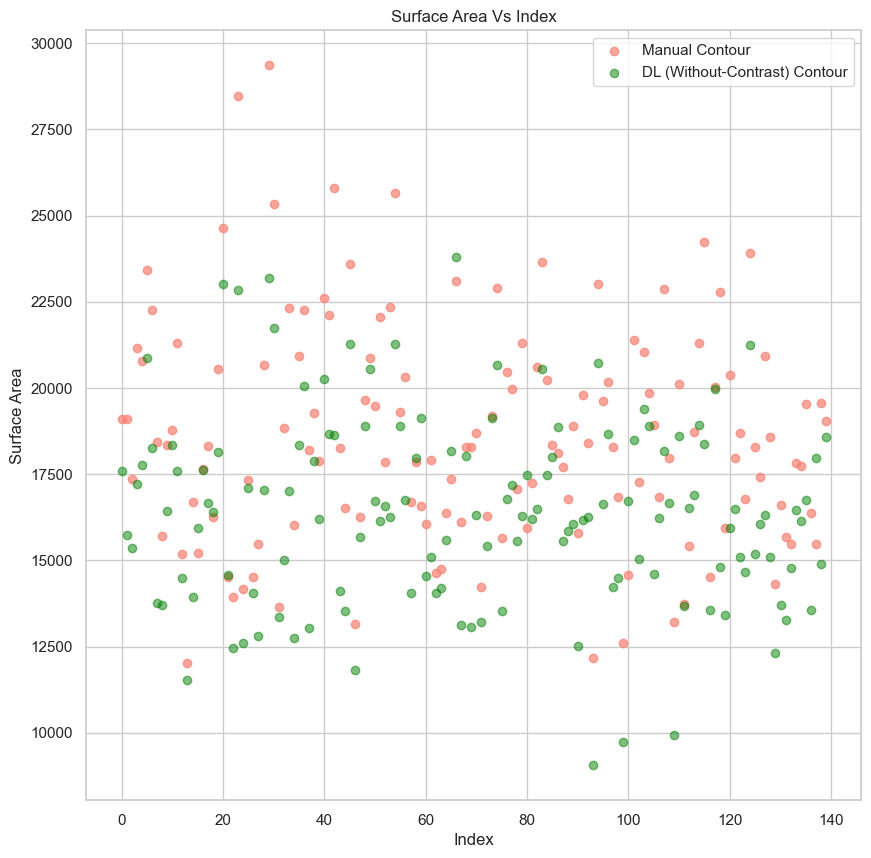

In [37]:
x_element_list = [mc.reset_index().index, mc.reset_index().index]
y_element_list = [mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Surface Area', 'title':'Surface Area Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

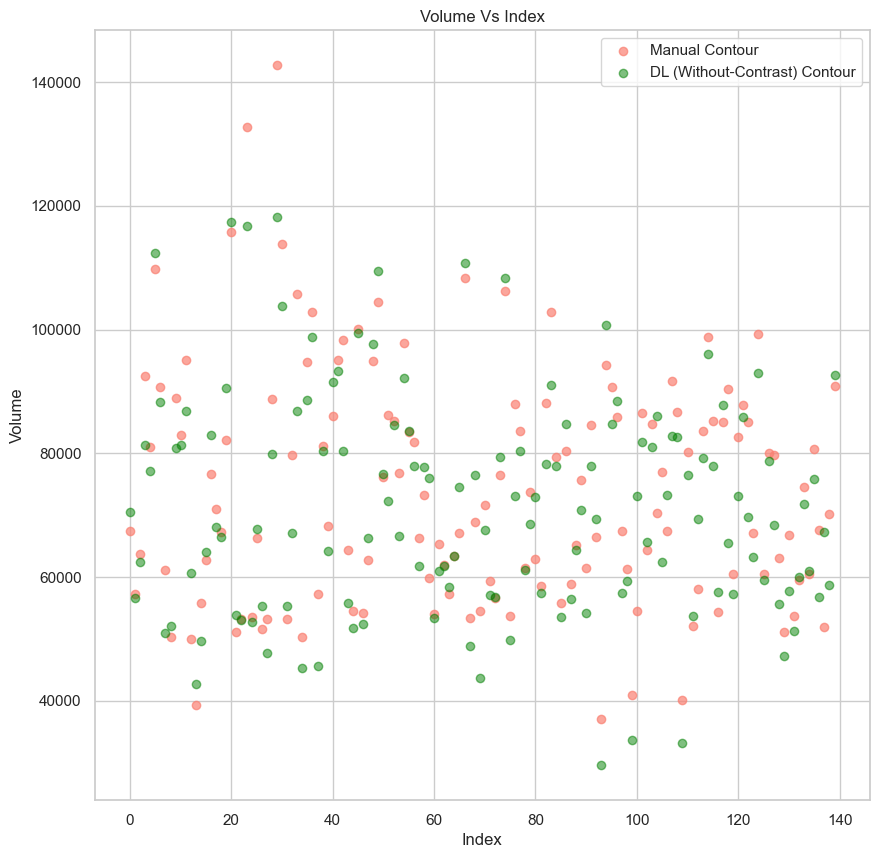

In [38]:
x_element_list = [mc.reset_index().index, mc.reset_index().index]
y_element_list = [mc.original_shape_VoxelVolume, dlc_without.original_shape_VoxelVolume]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Volume', 'title':'Volume Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram 

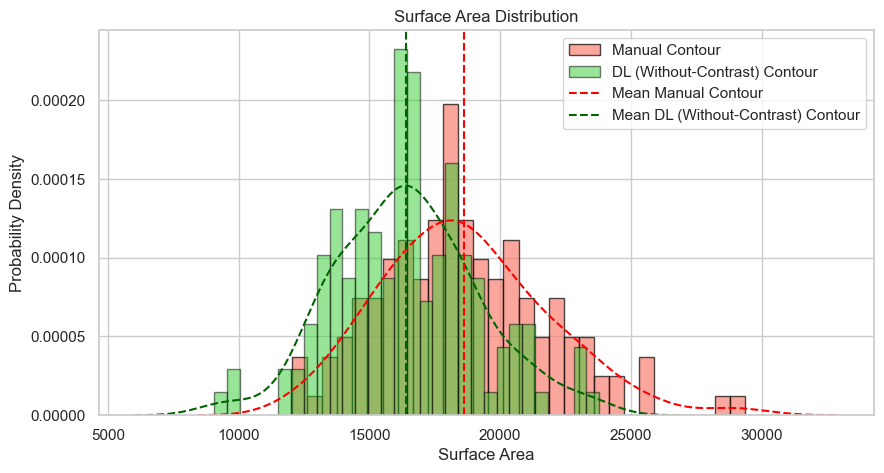

In [39]:
element_list = [mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area', 'y': 'Probability Density', 'title':'Surface Area Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

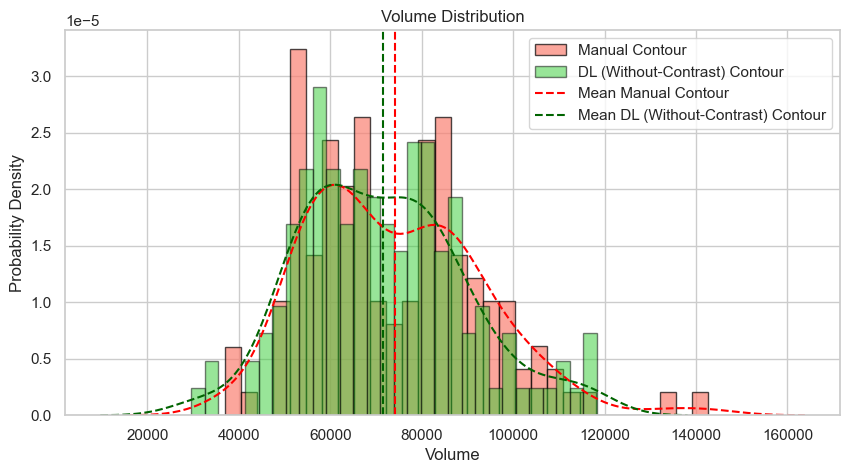

In [40]:
element_list = [mc.original_shape_VoxelVolume, dlc_without.original_shape_VoxelVolume]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Paired T-test


In [41]:
y1 = mc.original_shape_SurfaceArea
y2 = dlc_without.original_shape_SurfaceArea
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 1.86e+04, y.av.2 = 1.64e+04, s2.1 = 1.03e+07, s2.2 = 7.47e+06, n.1 = 140, n.2 = 140, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = 13.99, p-value = 2.632e-28, t.crit.L = -1.977, t.crit.R = 1.977, df = 139
Effect size: d.av = 0.74; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(13.989156903242376,
 2.632058812929097e-28,
 -1.9771777244761224,
 1.977177724476122)

In [42]:
y1 = mc.original_shape_VoxelVolume
y2 = dlc_without.original_shape_VoxelVolume
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 7.41e+04, y.av.2 = 7.14e+04, s2.1 = 3.57e+08, s2.2 = 3.17e+08, n.1 = 140, n.2 = 140, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = 4.357, p-value = 2.546e-05, t.crit.L = -1.977, t.crit.R = 1.977, df = 139
Effect size: d.av = 0.144; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(4.3568826720593234,
 2.5455779708693372e-05,
 -1.9771777244761224,
 1.977177724476122)

### Normalization


In [43]:
norm_without_vol = normalizing_feature(dlc_without.original_shape_VoxelVolume)
norm_without_surf = normalizing_feature(dlc_without.original_shape_SurfaceArea)

#### Scatter

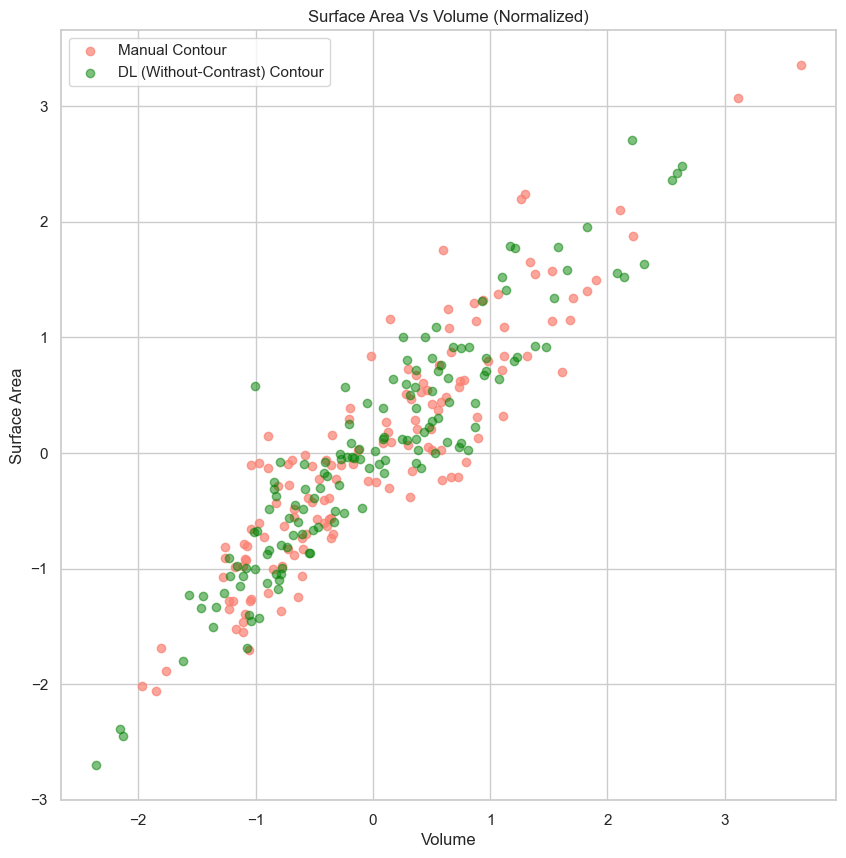

In [44]:
x_element_list = [norm_mc_vol, norm_without_vol]
y_element_list = [norm_mc_surf, norm_without_surf]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume (Normalized)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram

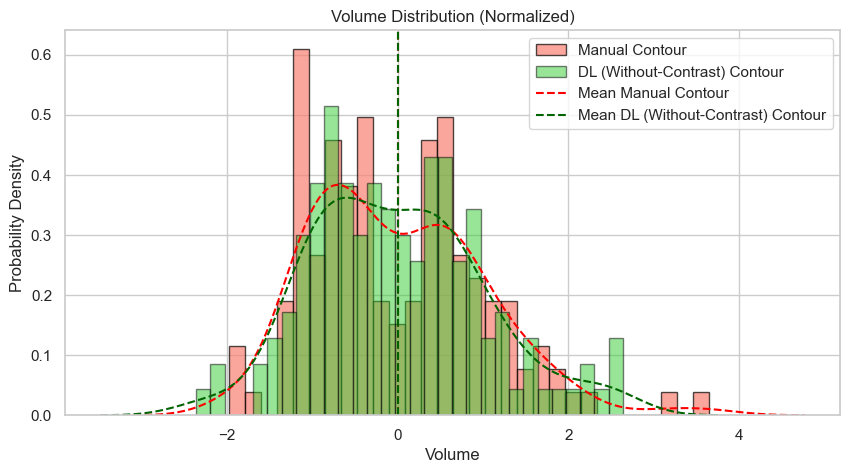

In [45]:
element_list = [norm_mc_vol, norm_without_vol]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

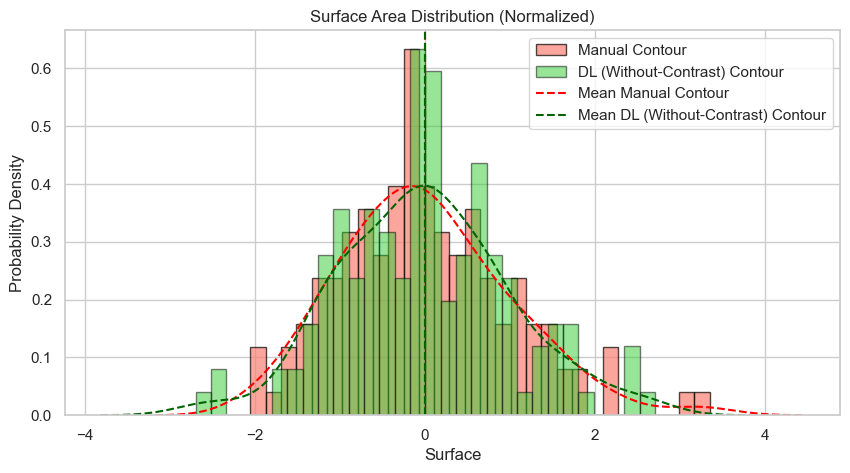

In [46]:
element_list = [norm_mc_surf, norm_without_surf]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface', 'y': 'Probability Density', 'title':'Surface Area Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Substraction

#### Surface

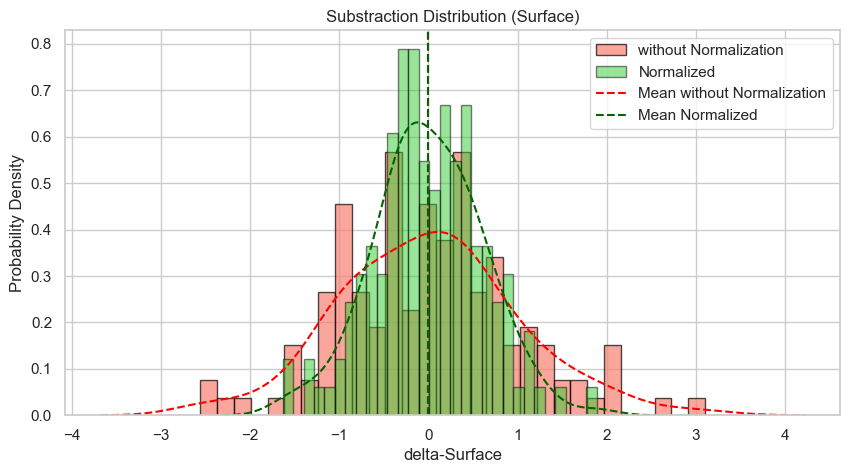

In [47]:
substratction = normalizing_feature(mc.original_shape_SurfaceArea - dlc_without.original_shape_SurfaceArea)
subtraction_norm = norm_mc_surf - norm_without_surf

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'delta-Surface', 'y': 'Probability Density', 'title':'Substraction Distribution (Surface)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

#### Volume

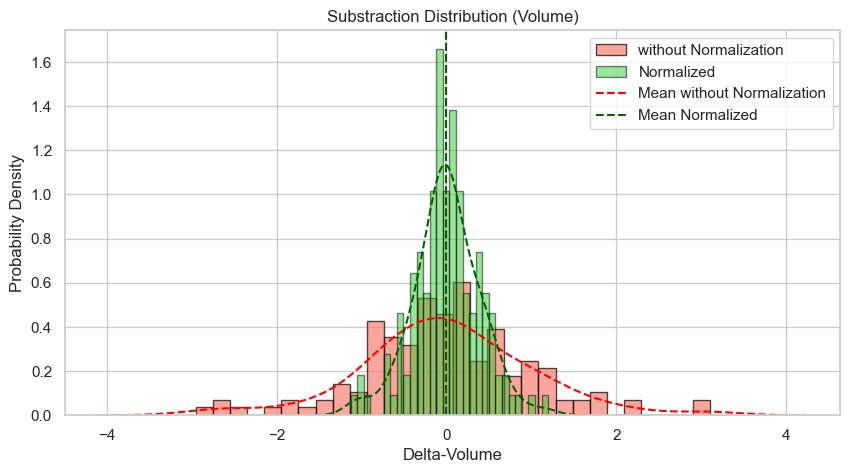

In [48]:
substratction = normalizing_feature(mc.original_shape_VoxelVolume - dlc_without.original_shape_VoxelVolume)
subtraction_norm = norm_mc_vol - norm_without_vol

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Volume', 'y': 'Probability Density', 'title':'Substraction Distribution (Volume)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

# With Contrast Vs Without Contrast
This is the las comparison for baseline. Then, I will go for WK3.

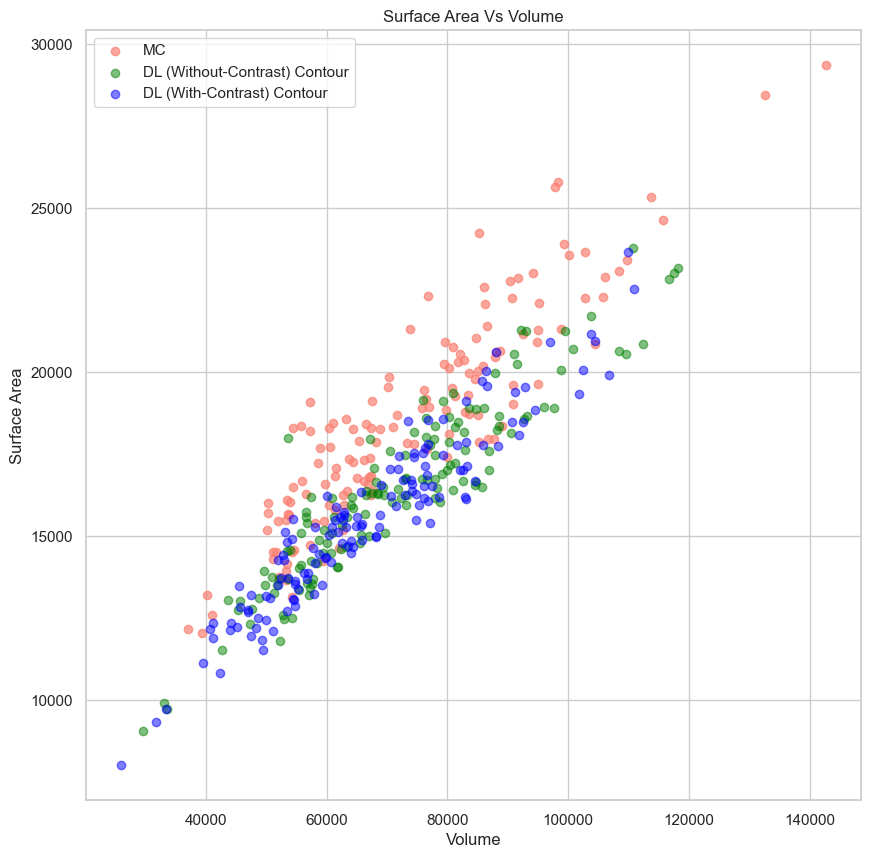

In [81]:
x_element_list = [mc.original_shape_VoxelVolume, dlc_without.original_shape_VoxelVolume, dlc_with.original_shape_VoxelVolume]
y_element_list = [mc.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea, dlc_with.original_shape_SurfaceArea]
color_list = ['salmon', 'green', 'blue']
label_list = ['MC', 'DL (Without-Contrast) Contour', 'DL (With-Contrast) Contour']
alpha_list = [0.7, 0.5, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram

#### Surface

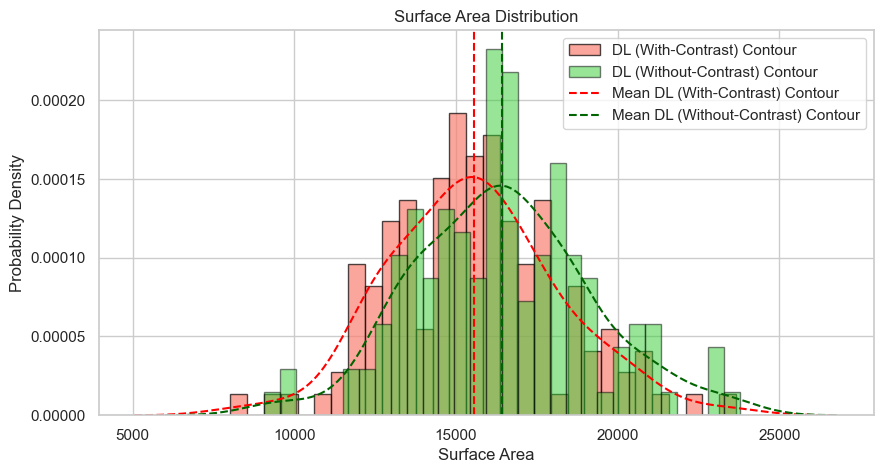

In [50]:
element_list = [dlc_with.original_shape_SurfaceArea, dlc_without.original_shape_SurfaceArea]
color_list = ['salmon', 'limegreen']
label_list = ['DL (With-Contrast) Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area', 'y': 'Probability Density', 'title':'Surface Area Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

#### Volume

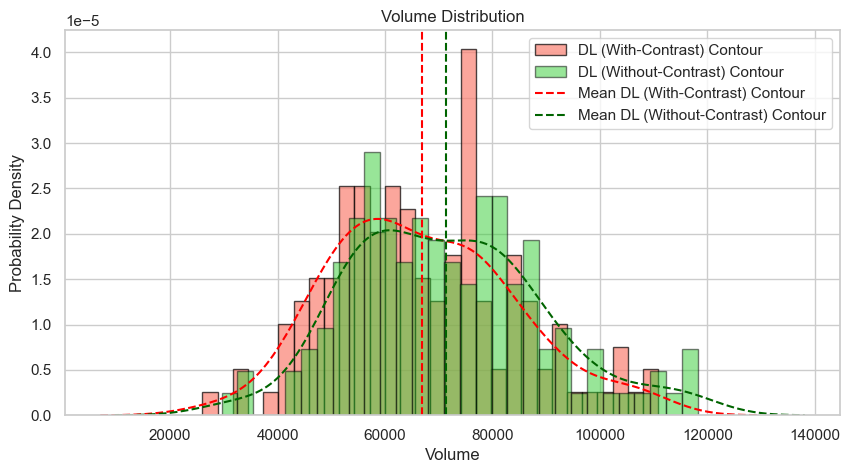

In [51]:
element_list = [dlc_with.original_shape_VoxelVolume, dlc_without.original_shape_VoxelVolume]
color_list = ['salmon', 'limegreen']
label_list = ['DL (With-Contrast) Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Paired T-test

In [52]:
y1 = dlc_with.original_shape_SurfaceArea
y2 = dlc_without.original_shape_SurfaceArea
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 1.55e+04, y.av.2 = 1.64e+04, s2.1 = 7.04e+06, s2.2 = 7.47e+06, n.1 = 140, n.2 = 140, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = -13.61, p-value = 2.483e-27, t.crit.L = -1.977, t.crit.R = 1.977, df = 139
Effect size: d.av = -0.321; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(-13.605650621997631,
 2.4834481343295994e-27,
 -1.9771777244761224,
 1.977177724476122)

In [53]:
y1 = dlc_with.original_shape_VoxelVolume
y2 = dlc_without.original_shape_VoxelVolume
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 6.69e+04, y.av.2 = 7.14e+04, s2.1 = 2.9e+08, s2.2 = 3.17e+08, n.1 = 140, n.2 = 140, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = -15.47, p-value = 5.147e-32, t.crit.L = -1.977, t.crit.R = 1.977, df = 139
Effect size: d.av = -0.261; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(-15.467563204612674,
 5.147489936672483e-32,
 -1.9771777244761224,
 1.977177724476122)

### Normalization

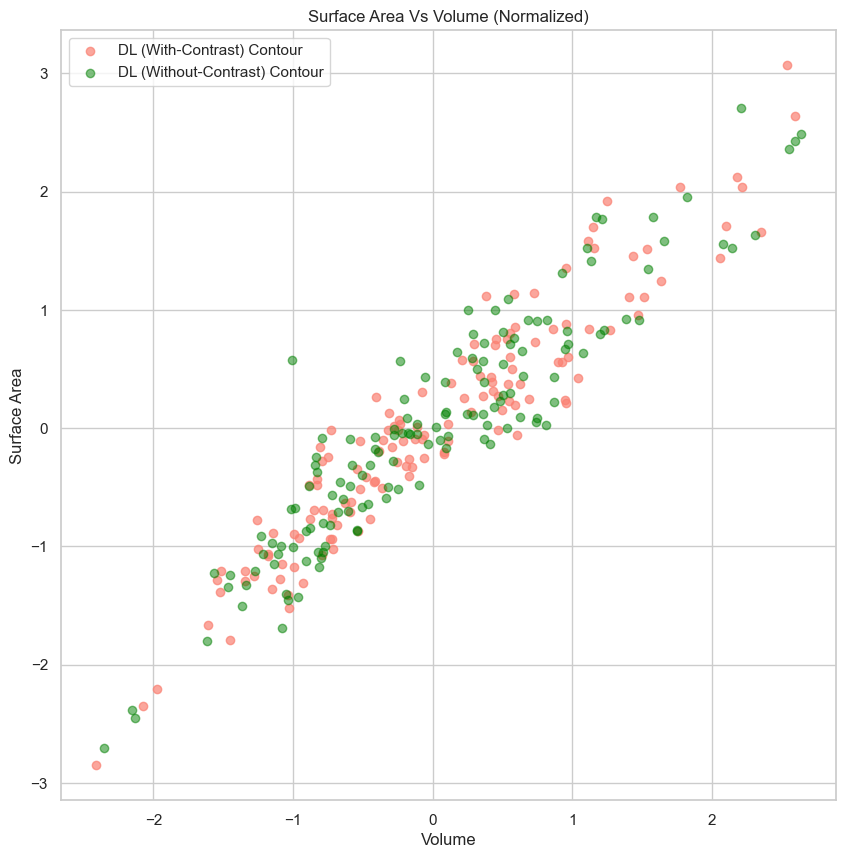

In [54]:
x_element_list = [norm_with_vol, norm_without_vol]
y_element_list = [norm_with_surf, norm_without_surf]
color_list = ['salmon', 'green']
label_list = ['DL (With-Contrast) Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume (Normalized)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram

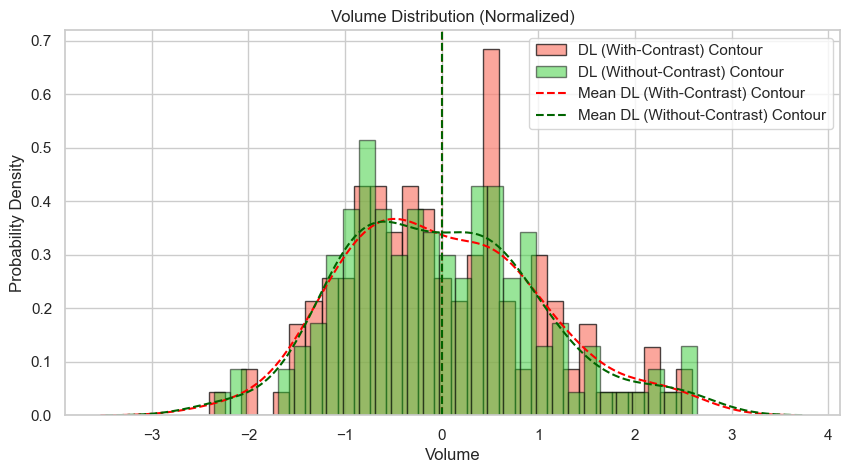

In [55]:
element_list = [norm_with_vol, norm_without_vol]
color_list = ['salmon', 'limegreen']
label_list = ['DL (With-Contrast) Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

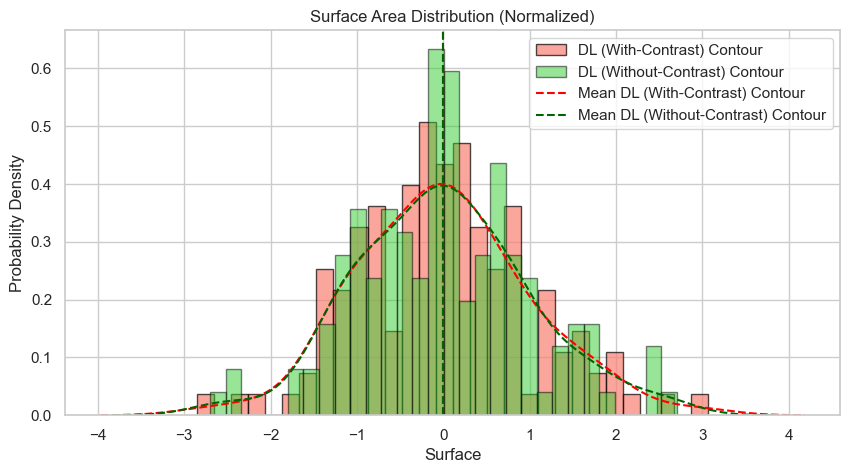

In [56]:
element_list = [norm_with_surf, norm_without_surf]
color_list = ['salmon', 'limegreen']
label_list = ['DL (With-Contrast) Contour', 'DL (Without-Contrast) Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface', 'y': 'Probability Density', 'title':'Surface Area Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Subtraction

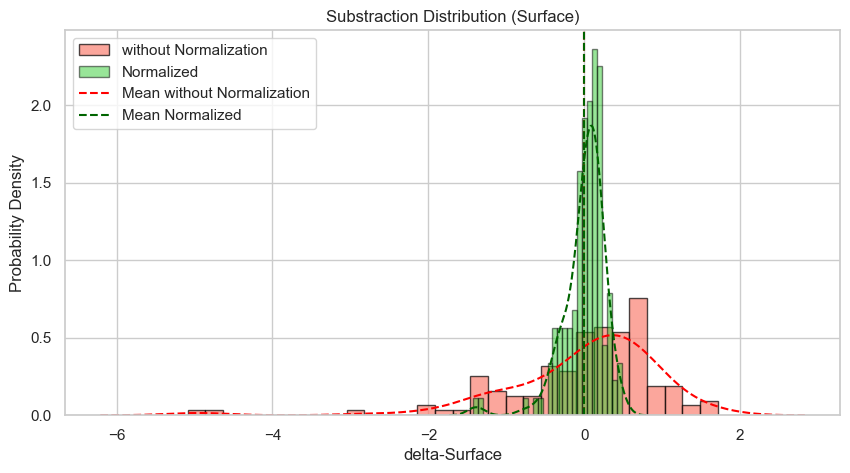

In [57]:
substratction = normalizing_feature(dlc_with.original_shape_SurfaceArea - dlc_without.original_shape_SurfaceArea)
subtraction_norm = norm_with_surf - norm_without_surf

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'delta-Surface', 'y': 'Probability Density', 'title':'Substraction Distribution (Surface)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

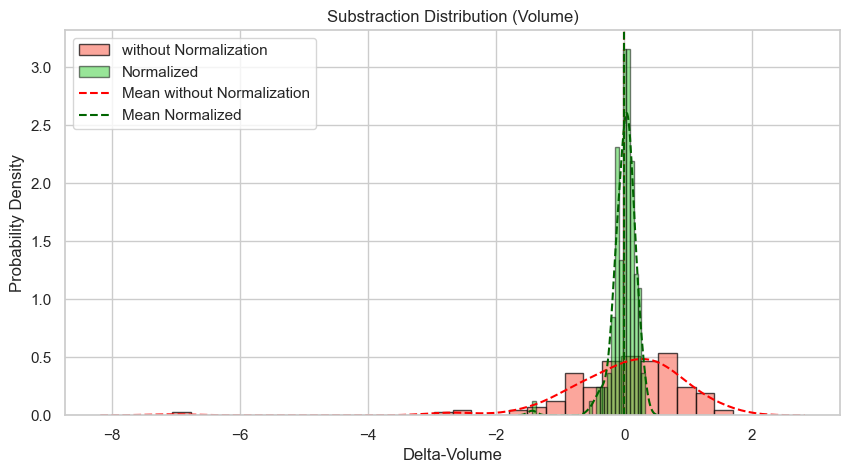

In [58]:
substratction = normalizing_feature(dlc_with.original_shape_VoxelVolume - dlc_without.original_shape_VoxelVolume)
subtraction_norm = norm_with_vol - norm_without_vol

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Volume', 'y': 'Probability Density', 'title':'Substraction Distribution (Volume)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

In [67]:
mc.original_shape_SurfaceArea.reset_index().dr

,ID,original_shape_SurfaceArea
0,339740,19112.125596
1,401057,19094.292611
2,585519,17368.828539
3,669746,21164.968648
4,694884,20782.246104
...,...,...
135,9152961,19523.201695
136,9462318,16382.286679
137,9577277,15470.493490
138,9946201,19558.607598


In [72]:
# Extract the relevant columns from each DataFrame
mc_data = mc[['original_shape_SurfaceArea']].reset_index(drop=True)
without_data = dlc_without[['original_shape_SurfaceArea']].reset_index(drop=True)
with_data = dlc_with[['original_shape_SurfaceArea']].reset_index(drop=True)

# Create the DataFrame
category_df = pd.DataFrame({'MC': mc_data['original_shape_SurfaceArea'],
                            'Without': without_data['original_shape_SurfaceArea'],
                            'With': with_data['original_shape_SurfaceArea']})

# Display the transposed DataFrame
category_df = category_df

In [73]:
category_df

,MC,Without,With
0,19112.125596,17598.200975,15727.827325
1,19094.292611,15740.193854,15121.042687
2,17368.828539,15346.849203,13635.437721
3,21164.968648,17226.854859,16872.924590
4,20782.246104,17780.974193,17550.071347
...,...,...,...
135,19523.201695,16748.005835,16380.424614
136,16382.286679,13562.393941,13376.807116
137,15470.493490,17967.988285,16238.649954
138,19558.607598,14886.766008,13543.628975


### Comparing C+ DLC, C- DLC, and MC

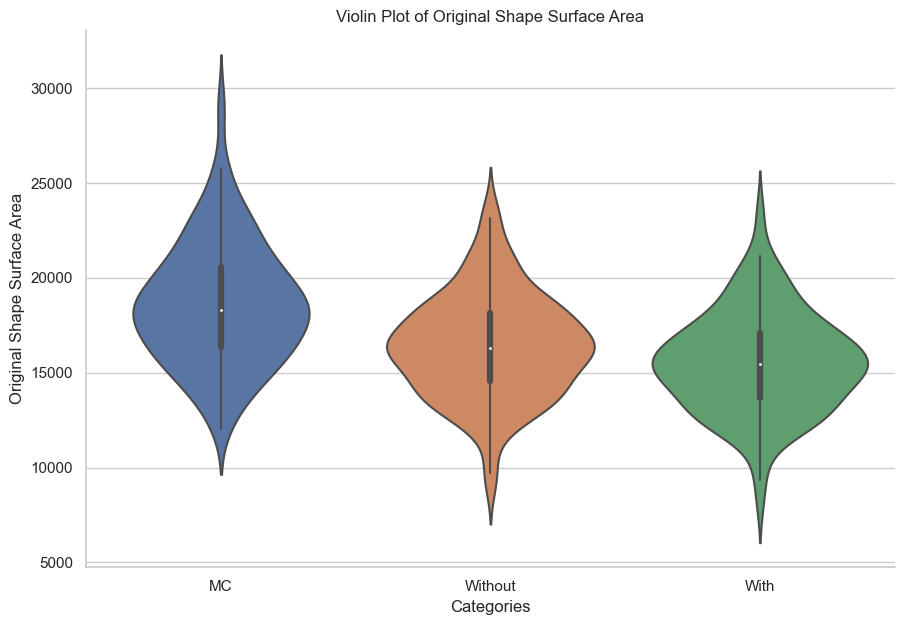

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the category_df DataFrame

# Create a violin plot using Seaborn
sns.set(style="whitegrid")
sns.catplot(kind='violin', data=category_df, height=6, aspect=1.5)

# Customize labels and title if needed
plt.xlabel('Categories')
plt.ylabel('Original Shape Surface Area')
plt.title('Violin Plot of Original Shape Surface Area')

plt.savefig('aaa.png')
# Show the plot
plt.show()

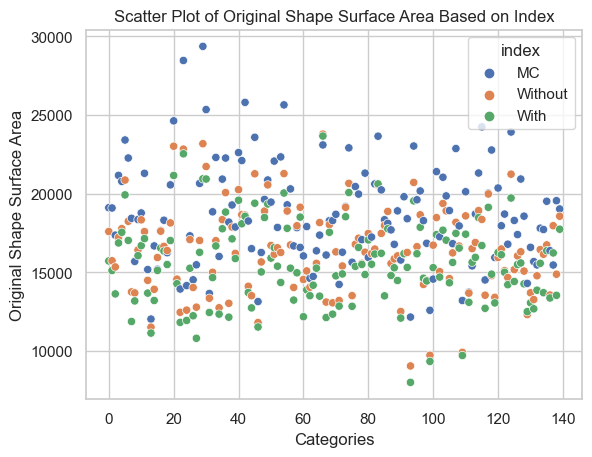

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the category_df DataFrame

# Melt the DataFrame to convert it to the long format for easier plotting
melted_df = category_df.transpose().reset_index().melt(id_vars='index', var_name='Category', value_name='Original Shape Surface Area')

# Create a scatter plot using Seaborn
sns.set(style="whitegrid")
sns.scatterplot(x='Category', y='Original Shape Surface Area', data=melted_df, hue='index')

# Customize labels and title if needed
plt.xlabel('Categories')
plt.ylabel('Original Shape Surface Area')
plt.title('Scatter Plot of Original Shape Surface Area Based on Index')

# Show the plot
plt.show()

# Week3
# Manual Contours Vs Deep Learning Contours
Here I have only one comparison since all the weekly CTs are without Contrast CTs.

In [372]:
mc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_mc_total.xlsx'
dlc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_dlc_total.xlsx'

In [373]:
# Make dataset with manual contouring and deep learning and without contrast.
mc_wk3_df = pd.read_excel(mc_wk3_path).drop(columns=['Unnamed: 0'])
dlc_wk3_df = pd.read_excel(dlc_wk3_path).drop(columns=['Unnamed: 0'])

In [374]:

dlc_wk3_df = dlc_wk3_df[dlc_wk3_df.ID.isin(list(mc_wk3_df.ID.unique()))]
mc_wk3_df = mc_wk3_df[mc_wk3_df.ID.isin(list(dlc_wk3_df.ID.unique()))]
mc_wk3_df.ID.nunique()

69

In [375]:
mc_wk3_total_df = mc_wk3_df[mc_wk3_df.OAR == 'total']
dlc_wk3_total_df = dlc_wk3_df[dlc_wk3_df.OAR == 'total']

dlc_wk3_total_df = dlc_wk3_total_df.set_index('ID').sort_index()
mc_wk3_total_df = mc_wk3_total_df.set_index('ID').sort_index()

mc_wk3 = mc_wk3_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]
dlc_wk3= dlc_wk3_total_df[['original_shape_VoxelVolume', 'original_shape_SurfaceArea']]

### Scatter

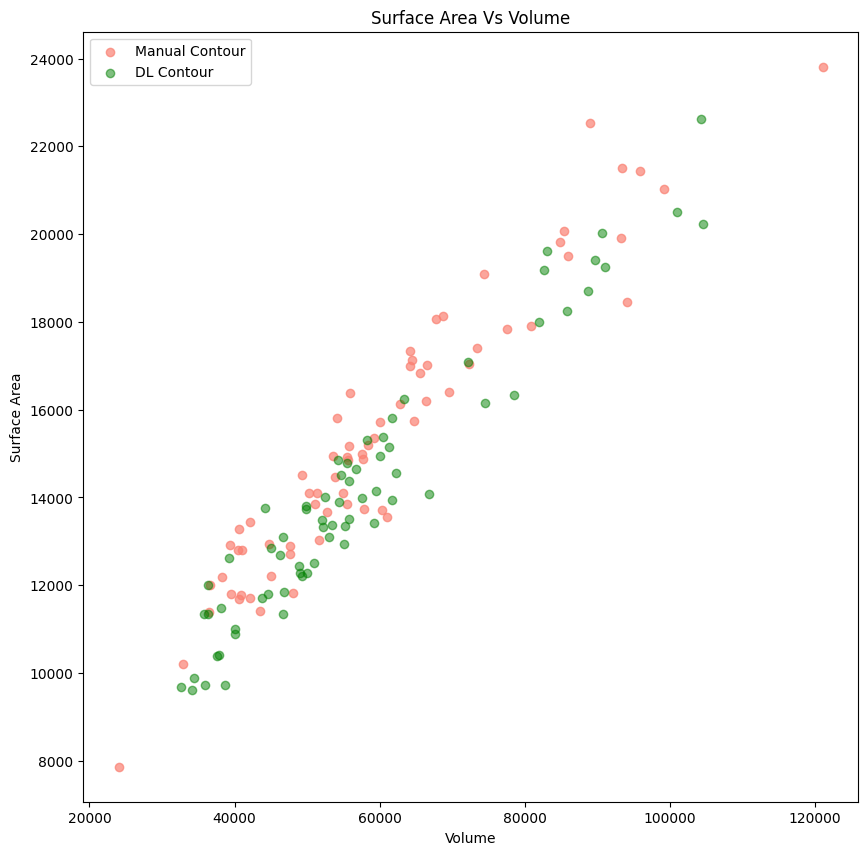

In [376]:
x_element_list = [mc_wk3.original_shape_VoxelVolume, dlc_wk3.original_shape_VoxelVolume]
y_element_list = [mc_wk3.original_shape_SurfaceArea, dlc_wk3.original_shape_SurfaceArea]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

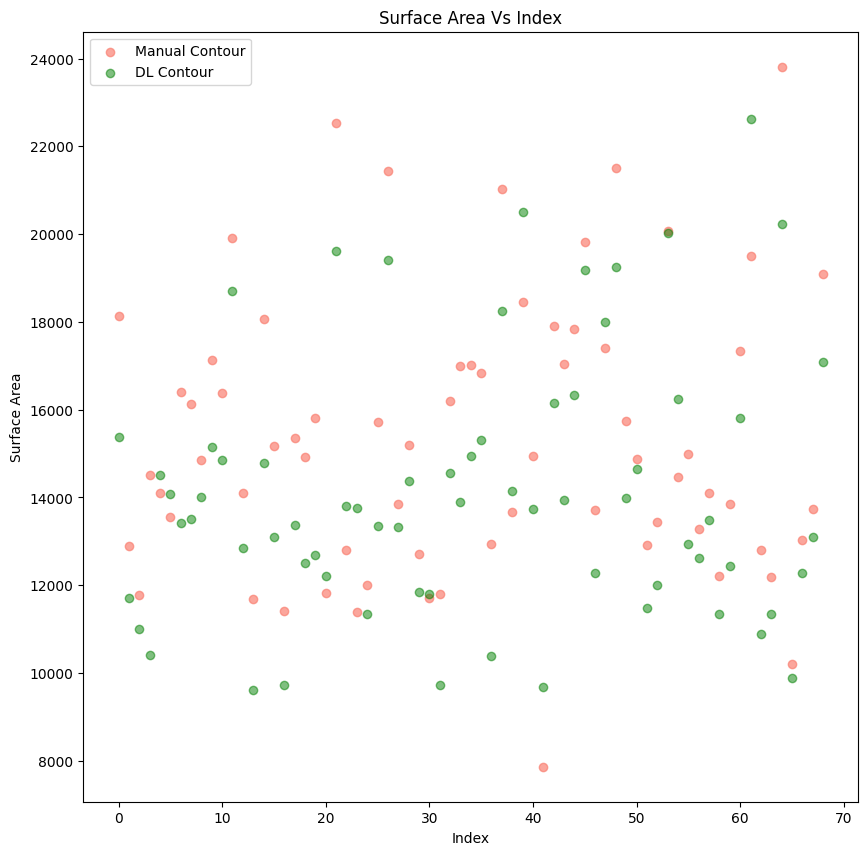

In [377]:
x_element_list = [mc_wk3.reset_index().index, mc_wk3.reset_index().index]
y_element_list = [mc_wk3.original_shape_SurfaceArea, dlc_wk3.original_shape_SurfaceArea]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Surface Area', 'title':'Surface Area Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

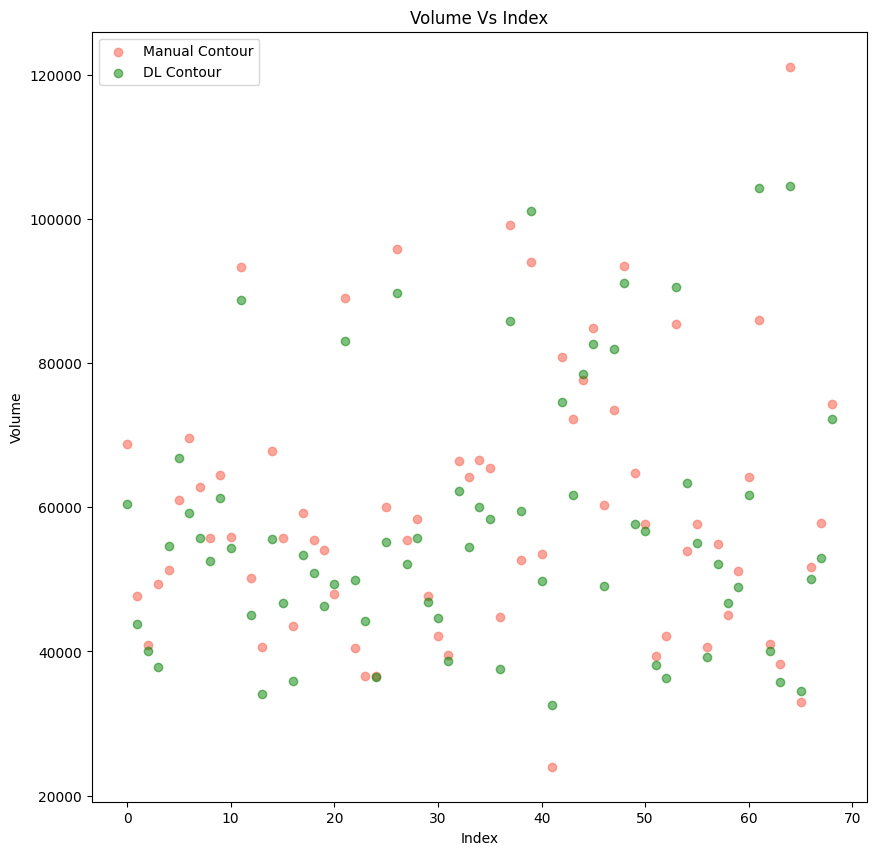

In [378]:
x_element_list = [mc_wk3.reset_index().index, mc_wk3.reset_index().index]
y_element_list = [mc_wk3.original_shape_VoxelVolume, dlc_wk3.original_shape_VoxelVolume]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Volume', 'title':'Volume Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

# Histogram

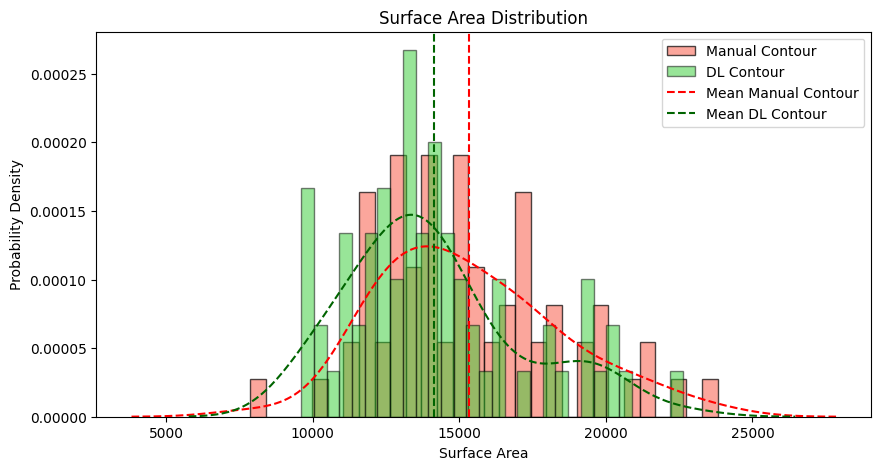

In [394]:
element_list = [mc_wk3.original_shape_SurfaceArea, dlc_wk3.original_shape_SurfaceArea]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface Area', 'y': 'Probability Density', 'title':'Surface Area Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

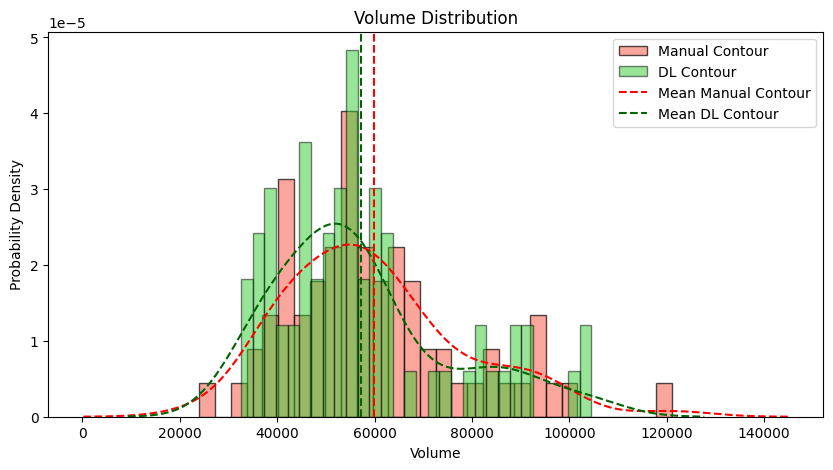

In [395]:
element_list = [mc_wk3.original_shape_VoxelVolume, dlc_wk3.original_shape_VoxelVolume]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

### Paired T-test

In [381]:
y1 = mc_wk3.original_shape_SurfaceArea
y2 = dlc_wk3.original_shape_SurfaceArea
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 1.53e+04, y.av.2 = 1.41e+04, s2.1 = 9.86e+06, s2.2 = 8.88e+06, n.1 = 69, n.2 = 69, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = 6.901, p-value = 2.136e-09, t.crit.L = -1.995, t.crit.R = 1.995, df = 68
Effect size: d.av = 0.394; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(6.9012327484668825,
 2.1356026907981546e-09,
 -1.9954689309194023,
 1.9954689309194018)

In [382]:
y1 = mc_wk3.original_shape_VoxelVolume
y2 = dlc_wk3.original_shape_VoxelVolume
DS_paired_ttest_means(y1, y2, alternative='two-sided', alpha=0.05)

--------------------------------------------------------------------------------
Paired t-test for 2 means:
     assuming Normal(mu.d, sigma2.d) data for difference between datasets 1 and 2
y.av.1 = 5.99e+04, y.av.2 = 5.73e+04, s2.1 = 3.42e+08, s2.2 = 3.25e+08, n.1 = 69, n.2 = 69, alpha = 0.05
H0: mu.1  = mu.2
H1: mu.1 != mu.2
t = 3.503, p-value = 0.0008189, t.crit.L = -1.995, t.crit.R = 1.995, df = 68
Effect size: d.av = 0.143; benchmarks |d.av|: 0.2 = small, 0.5 = medium, 0.8 = large
--------------------------------------------------------------------------------



(3.5026676460323705,
 0.0008189436032470904,
 -1.9954689309194023,
 1.9954689309194018)

# Normalization

In [383]:
norm_mc_vol = normalizing_feature(mc_wk3.original_shape_VoxelVolume)
norm_dlc_vol = normalizing_feature(dlc_wk3.original_shape_VoxelVolume)
norm_mc_surf = normalizing_feature(mc_wk3.original_shape_SurfaceArea)
norm_dlc_surf = normalizing_feature(dlc_wk3.original_shape_SurfaceArea)

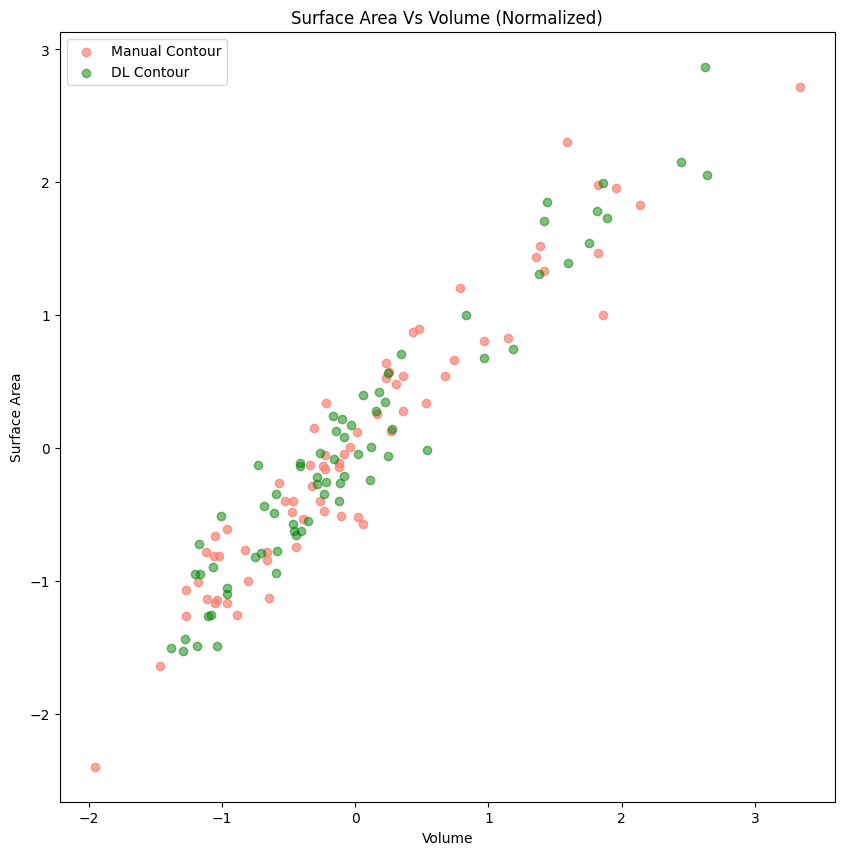

In [396]:

x_element_list = [norm_mc_vol, norm_dlc_vol]
y_element_list = [norm_mc_surf, norm_dlc_surf]
color_list = ['salmon', 'green']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Surface Area', 'title':'Surface Area Vs Volume (Normalized)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

### Histogram

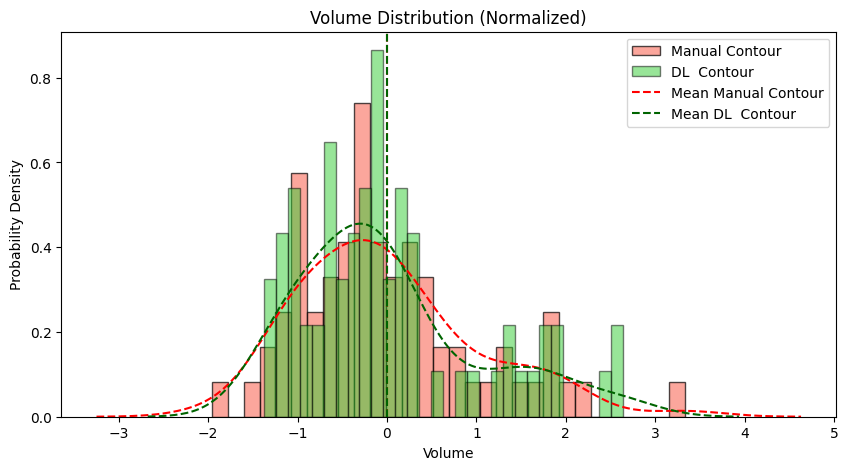

In [399]:
element_list = [norm_mc_vol, norm_dlc_vol]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL  Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Volume', 'y': 'Probability Density', 'title':'Volume Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)


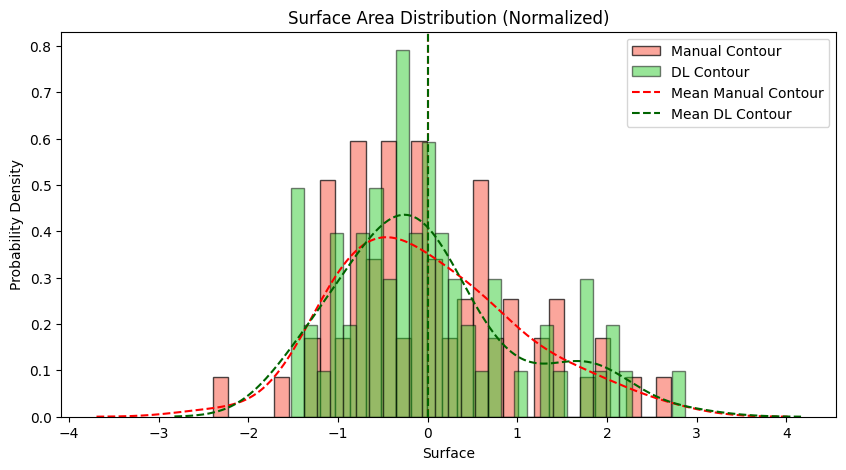

In [398]:

element_list = [norm_mc_surf, norm_dlc_surf]
color_list = ['salmon', 'limegreen']
label_list = ['Manual Contour', 'DL Contour']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Surface', 'y': 'Probability Density', 'title':'Surface Area Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

# Subtraction

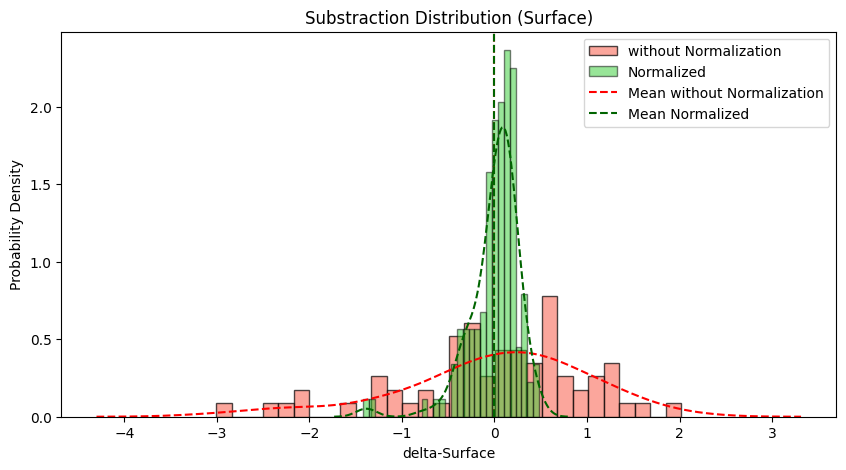

In [387]:
substratction = normalizing_feature(mc_wk3.original_shape_SurfaceArea - dlc_wk3.original_shape_SurfaceArea)
subtraction_norm = norm_with_surf - norm_without_surf

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'delta-Surface', 'y': 'Probability Density', 'title':'Substraction Distribution (Surface)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)


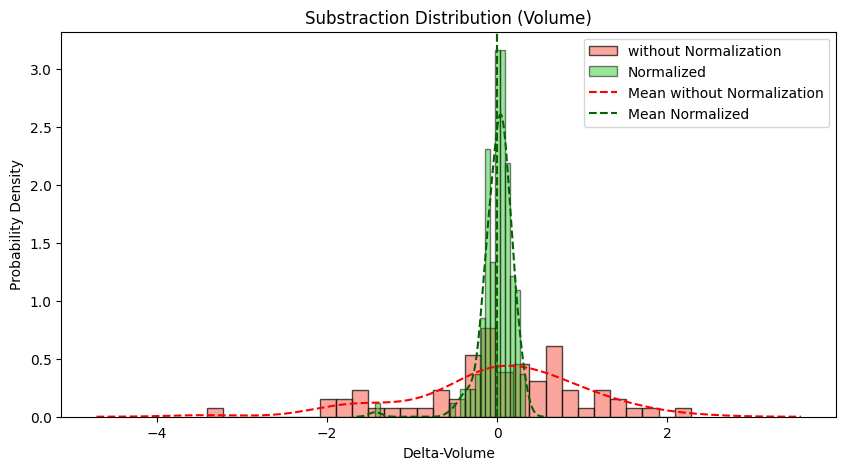

In [388]:
substratction = normalizing_feature(mc_wk3.original_shape_VoxelVolume - dlc_wk3.original_shape_VoxelVolume)
subtraction_norm = norm_with_vol - norm_without_vol

element_list = [substratction, subtraction_norm]
color_list = ['salmon', 'limegreen']
label_list = ['without Normalization', 'Normalized']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Volume', 'y': 'Probability Density', 'title':'Substraction Distribution (Volume)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

---

In [ ]:
fig = plt.figure()
plt.scatter(x=mc_surface.original_shape_VoxelVolume, y=mc_surface.original_shape_SurfaceArea, color='blue', alpha=0.7, marker='o')
plt.scatter(x=dlc_with_total_df.original_shape_VoxelVolume, y=dlc_with_total_df.original_shape_SurfaceArea, color='red', alpha=0.5, marker='o')
plt.scatter(x=dlc_without_total_df.original_shape_VoxelVolume, y=dlc_without_total_df.original_shape_SurfaceArea, color='green', alpha=0.5, marker='o')
# Add a legend
plt.legend()

# Show the plot
plt.show()

# Delta radiomics Statistical Comparison

In [ ]:
# Links
mc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_mc_total.xlsx'
dlc_wk3_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_wk3_dlc_total.xlsx'
mc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_mc_total.xlsx'
dlc_bsl_path = 'C:/Users/BahrdoH/OneDrive - UMCG/Hooman/Models/Preprocessing/Delta_radiomics/Feature_extraction_factory/Radiomics_features/Rf_bsl_dlc_total.xlsx'


# Read the dataframe.
mc_wk3_df = pd.read_excel(mc_wk3_path).drop(columns=['Unnamed: 0'])
dlc_wk3_df = pd.read_excel(dlc_wk3_path).drop(columns=['Unnamed: 0'])
mc_bsl_df = pd.read_excel(mc_bsl_path).drop(columns=['Unnamed: 0'])

# Convert the dlc baseline datafram in a comparieble way.
dlc_bsl_df = pd.read_excel(dlc_bsl_path)
dlc_bsl_df['Unnamed: 0'] = dlc_bsl_df['Unnamed: 0'].fillna(method='ffill')
dlc_bsl_df.rename(columns= {'Unnamed: 0':'ID', 'Unnamed: 1': 'OAR'}, inplace=True)
dlc_bsl_df.ID = dlc_bsl_df.ID.astype(int)
dlc_bsl_df.head()


# Slice the part of the dataset that Sanne used for her model.
dlc_wk3_df = dlc_wk3_df[dlc_wk3_df.ID.isin(list(mc_wk3_df.ID.unique()))]
mc_wk3_df = mc_wk3_df[mc_wk3_df.ID.isin(list(dlc_wk3_df.ID.unique()))]
mc_bsl_df = mc_bsl_df[mc_bsl_df.ID.isin(list(dlc_wk3_df.ID.unique()))]
dlc_bsl_df = dlc_bsl_df[dlc_bsl_df.ID.isin(list(dlc_wk3_df.ID.unique()))]

print('Number of patients per each dataset')
print(dlc_wk3_df.ID.nunique(), mc_wk3_df.ID.nunique(), mc_bsl_df.ID.nunique(), dlc_bsl_df.ID.nunique())

# Choose the total part
mc_wk3_total_df = mc_wk3_df[mc_wk3_df.OAR == 'total']
dlc_wk3_total_df = dlc_wk3_df[dlc_wk3_df.OAR == 'total']
mc_bsl_total_df = mc_bsl_df[mc_bsl_df.OAR == 'total']
dlc_bsl_total_df = dlc_bsl_df[dlc_bsl_df.OAR == 'total']

# Sort the datasets based on IDs
dlc_wk3_total_df = dlc_wk3_total_df.set_index('ID').sort_index()
mc_wk3_total_df = mc_wk3_total_df.set_index('ID').sort_index()
mc_bsl_total_df = mc_bsl_total_df.set_index('ID').sort_index()
dlc_bsl_total_df = dlc_bsl_total_df.set_index('ID').sort_index()

# Slice the surface area column
mc_wk3_surf = mc_wk3_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]
dlc_wk3_surf = dlc_wk3_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]
mc_bsl_surf = mc_bsl_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]
dlc_bsl_surf = dlc_bsl_total_df[['original_shape_SurfaceArea', 'original_shape_VoxelVolume']]

Number of patients per each dataset
69 69 69 69


In [ ]:
mc_delta_surf = mc_bsl_surf.original_shape_SurfaceArea - mc_wk3_surf.original_shape_SurfaceArea
dlc_delta_surf = dlc_bsl_surf.original_shape_SurfaceArea - dlc_wk3_surf.original_shape_SurfaceArea

mc_delta_vol = mc_bsl_surf.original_shape_VoxelVolume - mc_wk3_surf.original_shape_VoxelVolume
dlc_delta_vol = dlc_bsl_surf.original_shape_VoxelVolume - dlc_wk3_surf.original_shape_VoxelVolume

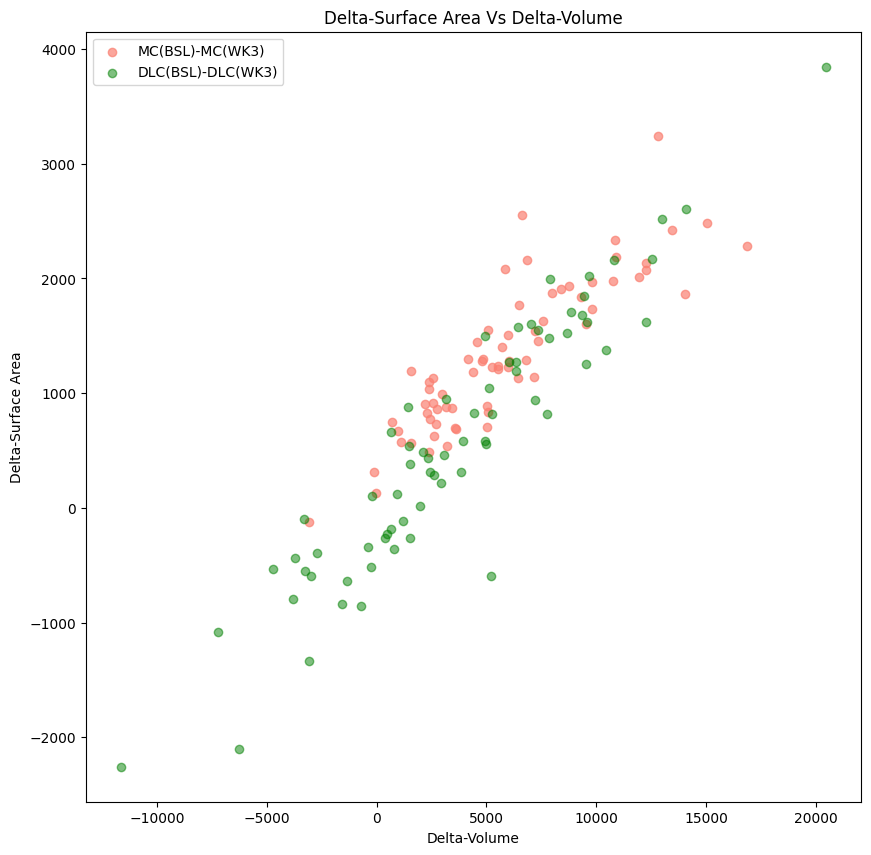

In [413]:
x_element_list = [mc_delta_vol, dlc_delta_vol]
y_element_list = [mc_delta_surf, dlc_delta_surf]
color_list = ['salmon', 'green']
label_list = ['MC(BSL)-MC(WK3)', 'DLC(BSL)-DLC(WK3)']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Volume', 'y': 'Delta-Surface Area', 'title':'Delta-Surface Area Vs Delta-Volume'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

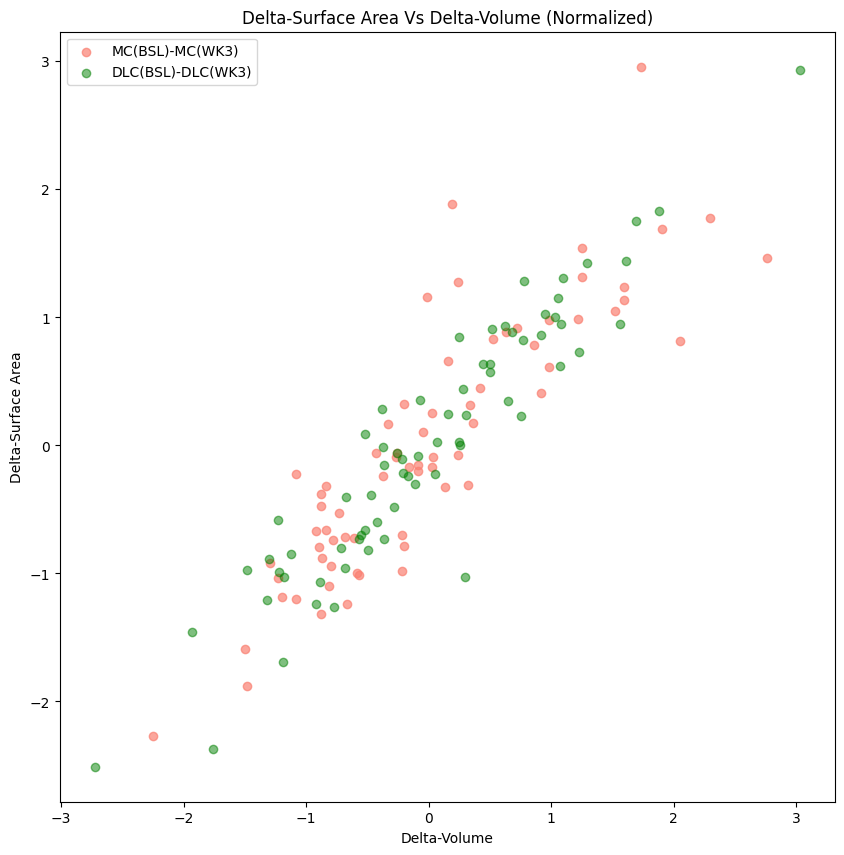

In [414]:

x_element_list = [normalizing_feature(mc_delta_vol), normalizing_feature(dlc_delta_vol)]
y_element_list = [normalizing_feature(mc_delta_surf), normalizing_feature(dlc_delta_surf)]
color_list = ['salmon', 'green']
label_list = ['MC(BSL)-MC(WK3)', 'DLC(BSL)-DLC(WK3)']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Volume', 'y': 'Delta-Surface Area', 'title':'Delta-Surface Area Vs Delta-Volume (Normalized)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

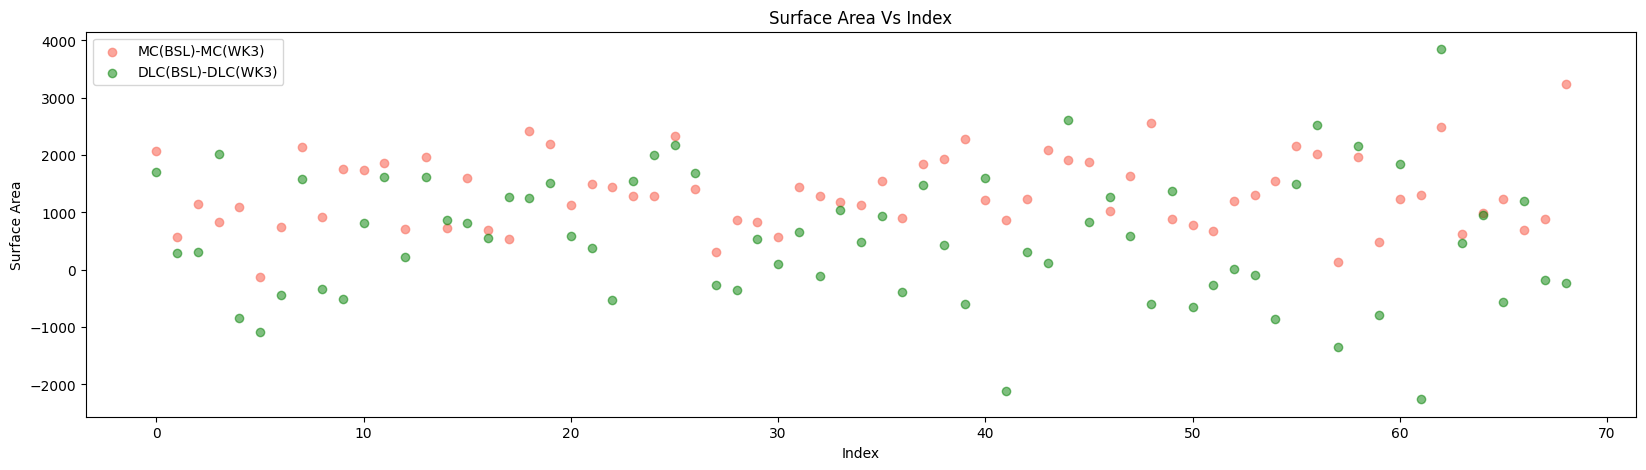

In [406]:
x_element_list = [mc_delta_surf.reset_index().index, mc_delta_surf.reset_index().index]
y_element_list = [mc_delta_surf, dlc_delta_surf]
color_list = ['salmon', 'green']
label_list = ['MC(BSL)-MC(WK3)', 'DLC(BSL)-DLC(WK3)']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Surface Area', 'title':'Surface Area Vs Index'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

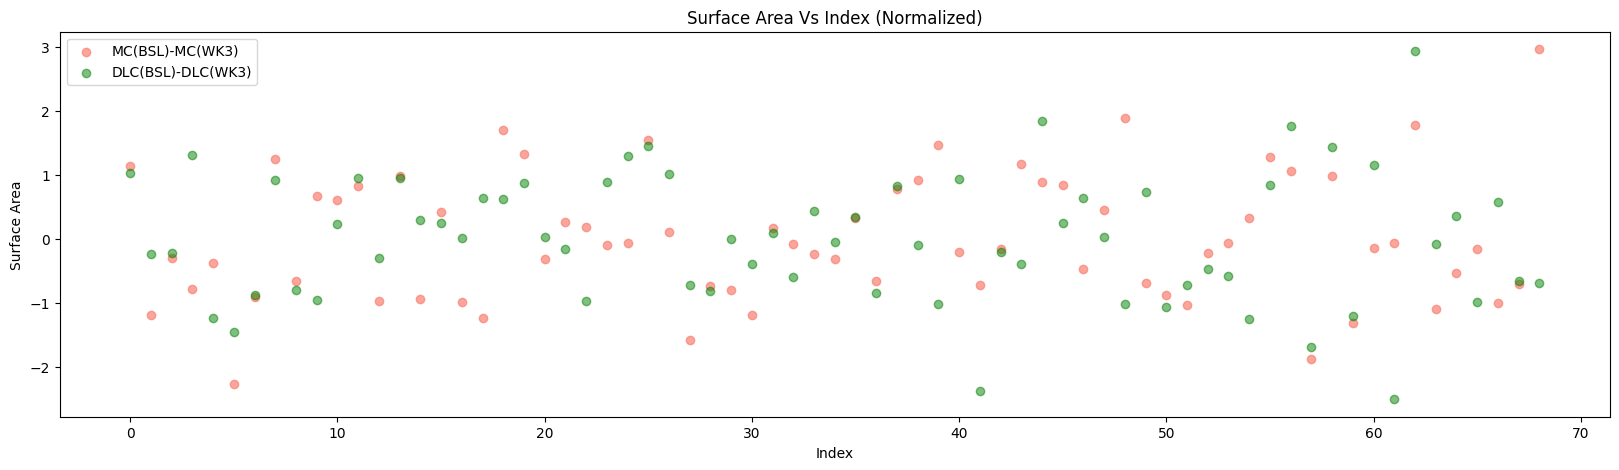

In [407]:
x_element_list = [mc_delta_surf.reset_index().index, mc_delta_surf.reset_index().index]
y_element_list = [normalizing_feature(mc_delta_surf), normalizing_feature(dlc_delta_surf)]
color_list = ['salmon', 'green']
label_list = ['MC(BSL)-MC(WK3)', 'DLC(BSL)-DLC(WK3)']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Index', 'y': 'Surface Area', 'title':'Surface Area Vs Index (Normalized)'} 
making_scatter_plot(x_element_list, y_element_list, color_list, label_list, alpha_list, figure_dict)

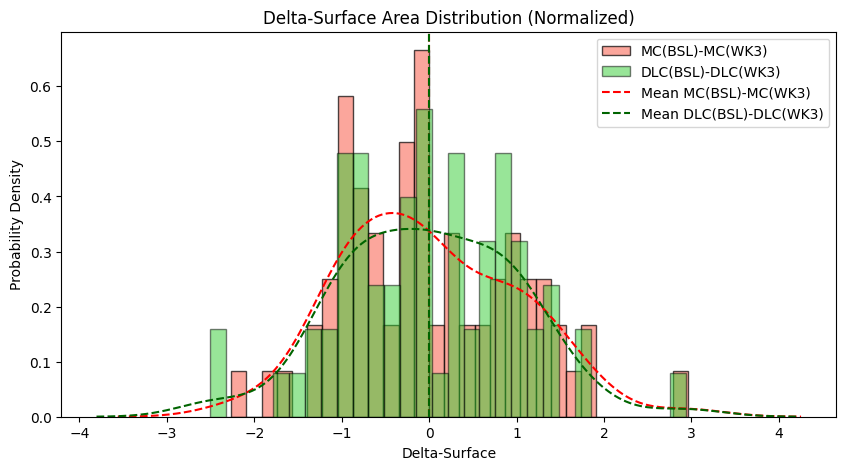

In [417]:
element_list = [normalizing_feature(mc_delta_surf), normalizing_feature(dlc_delta_surf)]
color_list = ['salmon', 'limegreen']
label_list = ['MC(BSL)-MC(WK3)', 'DLC(BSL)-DLC(WK3)']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Surface', 'y': 'Probability Density', 'title':'Delta-Surface Area Distribution (Normalized)'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)

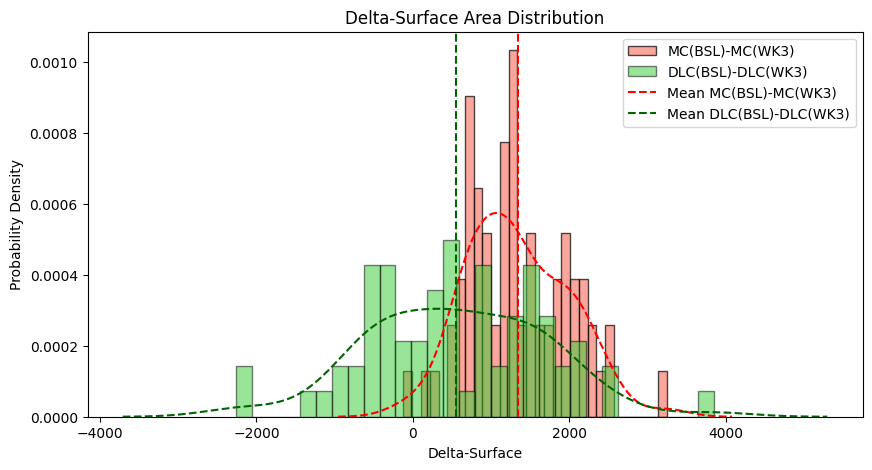

In [416]:
element_list = [mc_delta_surf, dlc_delta_surf]
color_list = ['salmon', 'limegreen']
label_list = ['MC(BSL)-MC(WK3)', 'DLC(BSL)-DLC(WK3)']
alpha_list = [0.7, 0.5]
figure_dict = {'x': 'Delta-Surface', 'y': 'Probability Density', 'title':'Delta-Surface Area Distribution'} 
making_histogram(element_list, color_list, label_list, alpha_list, figure_dict)